**TopBank Company business model**
* The company sells banking services to its customers through physical branches and an online portal.
* Offers financial products such as bank account, investments and insurance.
* Main Product: bank account without costs, valid for 12 months. After this period, the account must be renovated.
* Bank return per client:
 * 15% if client's income is lower than the average;
 * 20% if client's income is higher than the average;

**Problem**
* In the last few months the rate of customers canceling their accounts and leaving the bank had a significant increase;

**Goal**
* Reduce customer evasion, aka **churn rate**;
*  Distribute financial incentives among clients in order to maximize ROI (Return on Investment).
*  The sum of incentives for each client cannot exceed R$10,000.00;

**Deliverables**
* Answer following questions:
 * What is TopBank's current Churn rate? 
 * How does it vary monthly?
 * What is the model's performance in classifying customers as churns?
 * What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?
* Maximize ROI;
* Deployed model that receives a customers database through API and returns the probability if client churning;

**DATA**
* RowNumber: corresponds to the record (row) number and has no effect on the output.
* CustomerId: contains random values and has no effect on customer leaving the bank.
* Surname: the surname of a customer has no impact on their decision to leave the bank.
* CreditScore: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
* Geography: a customer’s location can affect their decision to leave the bank.
* Gender: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
* Age: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
* Tenure: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
* Balance: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
* NumOfProducts: refers to the number of products that a customer has purchased through the bank.
* HasCrCard: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
* IsActiveMember: active customers are less likely to leave the bank.
* EstimatedSalary: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
* Exited: whether or not the customer left the bank. (0=No,1=Yes)

# IMPORTS

In [132]:
import pandas as pd
import numpy as np
import random
#for scaling
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
#for plots
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
#for stats
from scipy import stats as ss
#for ML
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models as ml
from tensorflow.keras import layers as l
from tensorflow.keras.callbacks import EarlyStopping
# for feature selection
from boruta import BorutaPy
#for splitting data
from sklearn import model_selection as ms
#for metrics
from sklearn import metrics as m
from scikitplot import metrics as mt
#for fine tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
#for clustering
from sklearn.cluster import KMeans
#for saving scaler
import joblib
#for oversampling
from imblearn import over_sampling as oversamp
from imblearn import combine as c

In [2]:
SEED=42

In [3]:
data = pd.read_csv('churn.csv')

In [4]:
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
# Since no test data was given I will split the data between train and test
x=data.drop(['Exited'],axis=1)
y=data['Exited']
xtrain, xtest, ytrain, ytest = ms.train_test_split(x,y,test_size=0.20,random_state=SEED)

In [6]:
train_set=pd.concat([xtrain,ytrain],axis=1)
test_set=pd.concat([xtest,ytest],axis=1)

## Helper functions

In [133]:
# 0-1 knapsack function
# W: weight constraint
# wt: weight of each item
# val: value of each item
def knapsack(W, wt, val):
    n = len(val) # number of items in val
    # set a Table "K" with all values equal zero
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    # loop in rows of Table "K"
    for i in range(n + 1):
        # loop in columns of Table "K"
        for w in range(W + 1):
            if i == 0  or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    
    # select chosen items that maximizes the output value
    # create a list with 'n' False items
    keep = [False] * n
    res = max_val
    w = W
    # decrescent loop
    for i in range(n, 0, -1):
        if res <= 0: break # break statement terminates the loop
        # continue statement skips the rest of the code inside a loop for the current iteration only.
        # Loop does not terminate but continues on with the next iteration.
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

In [7]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [8]:
# make list of variables types
def variable_types(data):
    # numerical: discrete and continuous
    continuous = [var for var in data.columns if data[var].dtype == 'float64']
    discrete = [var for var in data.columns if data[var].dtype == 'int64' and data[var].nunique() > 2]
    date = [var for var in data.columns if data[var].dtype == '<M8[ns]']
    categorical = [var for var in list( set(data.columns)-set(data[continuous+discrete+date].columns) )]

    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))
    print('There are {} date_time variables'.format(len(date)))
    
    return discrete,continuous,categorical,date

In [9]:
def cross_validation( target, data2crossv, kfold, model_name, model, sampler=None):
    acc_list = []
    balanced_acc_list = []
    f1_list = []
    kappa_list = []
    
    kfold = ms.StratifiedKFold( n_splits=kfold, shuffle=True, random_state=SEED )
#     tscv = TimeSeriesSplit(n_splits=kfold)
    
    #data2crossv.set_index(['date'])
    X=data2crossv.drop(target,axis=1)
    Y=data2crossv[target]
    
    for train_index,test_index in kfold.split(X,Y):
        
        #splitting
        xtraining, xvalidation, ytraining, yvalidation = X.values[train_index], X.values[test_index], \
                                       Y.values[train_index], Y.values[test_index]
        
        if sampler:
            xtraining, ytraining = sampler.fit_sample(xtraining, ytraining)
                
        # model and prediction
        if model_name=='Neural Net':
            model.add( l.Dense( units=16, input_dim=xtraining.shape[1], activation='relu' ) )
            model.add( l.Dense( units=8, activation='relu') )
            model.add( l.Dropout(0.2) )
            model.add( l.Dense( units=1, activation='sigmoid') )
            model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
            model.fit( xtraining, ytraining, epochs=100, validation_data=(xvalidation, yvalidation), verbose=0, callbacks=[early_stop])
            yhat = model.predict_classes(xvalidation)
        else:
            m = model.fit( xtraining, ytraining.ravel() )
            yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, yvalidation, yhat)

        # store performance of each kfold iteration
#         acc_list.append(  m_result['Accuracy'] )
        rec_list.append(  m_result['Recall'] )
        balanced_acc_list.append( m_result['Balanced accuracy'] )
        f1_list.append( m_result['F1 score'] )
        kappa_list.append( m_result['Kappa Metrics'] )
        
    return pd.DataFrame( {'Model Name': model_name,
#                           'Accuracy CV': np.round( np.mean( acc_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( acc_list ), 4 ).astype( str ),
                          'Recall CV': np.round( np.mean( rec_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( rec_list ), 4 ).astype( str ),
                          'Balanced ACC CV': np.round( np.mean( balanced_acc_list ), 4).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list ), 4 ).astype( str ),
                          'F1 CV': np.round( np.mean( f1_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( f1_list ), 4 ).astype( str ),
                          'Kappa CV': np.round( np.mean( kappa_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_list ), 4 ).astype( str )
                         }, index=[0] )

In [10]:
def ml_error( model_name, y, yhat ):
    # Accuracy
#     acc = m.accuracy_score( y, yhat )
    # Recall
    rec = m.recall_score( y, yhat )
    # Balanced Accuracy
    balanced_acc = m.balanced_accuracy_score( y, yhat )
    # F1 score
    f1 = m.f1_score( y, yhat )
    # Kappa Metrics
    kappa = m.cohen_kappa_score( y, yhat )
    
    return pd.DataFrame( { 'Model Name': model_name, 
#                            'Accuracy': acc,
                           'Recall': rec,
                           'Balanced accuracy': balanced_acc,
                           'F1 score': f1, 
                           'Kappa Metrics': kappa
                         }, index=[0] )

# DATA DESCRIPTION

In [11]:
df1=train_set.copy()

## Variables inspection

**Analysis**

Variables:

Continuous:  ['Balance', 'EstimatedSalary'] 

Discrete:  ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'NumOfProducts'] 

Categorical:  ['HasCrCard', 'IsActiveMember', 'Exited', 'Gender', 'Geography', 'Surname'] 

Date_time:  [] 


Row number and customer ID contains no information

In [12]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 8000
Number of columns: 14


In [13]:
df1.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5012.506875,1.569067e+07,651.647625,38.897750,5.003875,76102.139645,1.531375,0.703500,0.512750,100431.289764,0.205500
std,2887.649416,7.184743e+04,96.366200,10.518953,2.881822,62461.005757,0.579705,0.456743,0.499869,57518.920431,0.404092
min,2.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,2512.750000,1.562822e+07,585.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51364.125000,0.000000
50%,5014.500000,1.569074e+07,653.000000,37.000000,5.000000,96447.520000,1.000000,1.000000,1.000000,100487.720000,0.000000
75%,7505.250000,1.575316e+07,719.000000,44.000000,7.000000,127611.332500,2.000000,1.000000,1.000000,149595.842500,0.000000
max,10000.000000,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000


In [14]:
df1.nunique()

RowNumber          8000
CustomerId         8000
Surname            2618
CreditScore         457
Geography             3
Gender                2
Age                  67
Tenure               11
Balance            5082
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    7999
Exited                2
dtype: int64

In [15]:
# let's inspect the variable values proportion

for var in df1.columns:
    print(var, '\n', df1[var].value_counts(normalize=True).head(10)*100, '\n')

RowNumber 
 2047    0.0125
1378    0.0125
1354    0.0125
3403    0.0125
9550    0.0125
5456    0.0125
7505    0.0125
1362    0.0125
9558    0.0125
5464    0.0125
Name: RowNumber, dtype: float64 

CustomerId 
 15812607    0.0125
15770974    0.0125
15580493    0.0125
15754574    0.0125
15622003    0.0125
15621457    0.0125
15715667    0.0125
15646037    0.0125
15707479    0.0125
15785899    0.0125
Name: CustomerId, dtype: float64 

Surname 
 Smith       0.3000
Shih        0.3000
Genovese    0.2875
Martin      0.2875
Yeh         0.2750
Brown       0.2750
Wright      0.2625
Walker      0.2500
Wang        0.2500
Maclean     0.2500
Name: Surname, dtype: float64 

CreditScore 
 850    2.3875
678    0.6125
655    0.6125
667    0.6125
684    0.5625
705    0.5500
651    0.5125
645    0.5125
648    0.5125
660    0.5000
Name: CreditScore, dtype: float64 

Geography 
 France     49.9250
Germany    25.1375
Spain      24.9375
Name: Geography, dtype: float64 

Gender 
 Male      54.525
Female    45.47

In [16]:
# let's inspect the variable values

for var in df1.columns:
    print(var, df1[var].unique()[0:20], '\n')

RowNumber [9255 1562 1671 6088 6670 5934 8830 7946 3509 2003 5867  169 2589 5906
 9530 6385 7825 9780 4630 8561] 

CustomerId [15601116 15766374 15716994 15730759 15797900 15594340 15769955 15654870
 15614230 15657214 15600392 15574692 15663885 15731519 15661708 15812073
 15761149 15712568 15687153 15599386] 

Surname ["P'an" 'Leak' 'Green' 'Chukwudi' 'Chinomso' 'Tao' 'Onuora' 'Longo' "T'an"
 'Hsia' 'Amaechi' 'Pinto' 'Blinova' 'Kerr' 'She' 'Palmer' 'Teng' 'Angelo'
 'Graham' 'Black'] 

CreditScore [686 632 559 561 517 569 683 759 426 601 735 667 741 511 508 529 673 515
 850 627] 

Geography ['France' 'Germany' 'Spain'] 

Gender ['Male' 'Female'] 

Age [32 42 24 27 56 41 40 45 34 74 53 39 30 31 44 49 28 36 35 37] 

Tenure [ 6  4  3  9  1  8  2  5  7 10  0] 

Balance [     0.   119624.6  114739.92 135637.   142147.32 120243.49 123845.36
 133444.97 121355.99  98649.55  71097.23 117559.05  95853.39 121030.9
 126315.26 161814.64 113688.63  57657.49 149989.39 138190.13] 

NumOfProducts [2 1 3

In [17]:
df1['RowNumber'].dtype

dtype('int64')

In [18]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [19]:
discrete,continuous,categorical,dates=variable_types(df1)

There are 6 discrete variables
There are 2 continuous variables
There are 6 categorical variables
There are 0 date_time variables


In [20]:
print('Continuous: ',continuous,'\n')
print('Discrete: ',discrete,'\n')
print('Categorical: ',categorical,'\n')
print('Date_time: ',dates,'\n')

Continuous:  ['Balance', 'EstimatedSalary'] 

Discrete:  ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'NumOfProducts'] 

Categorical:  ['Geography', 'Exited', 'Gender', 'IsActiveMember', 'Surname', 'HasCrCard'] 

Date_time:  [] 



## Check NAs

**Analysis**

No NAs

In [21]:
df1.isna().sum() / len( df1 )

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

## Descriptive Analysis

### Continuous

In [22]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( df1[continuous].apply( np.mean ) ).T
ct2 = pd.DataFrame( df1[continuous].apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( df1[continuous].apply( np.std ) ).T
d2 = pd.DataFrame( df1[continuous].apply( min ) ).T
d3 = pd.DataFrame( df1[continuous].apply( max ) ).T
d4 = pd.DataFrame( df1[continuous].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1[continuous].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1[continuous].apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Balance,0.00,250898.09,250898.09,76102.139645,96447.52,62457.101822,-0.129407,-1.493190
1,EstimatedSalary,90.07,199970.74,199880.67,100431.289764,100487.72,57515.325387,-0.004443,-1.180224


### Discrete

In [23]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( df1[discrete].apply( np.mean ) ).T
ct2 = pd.DataFrame( df1[discrete].apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( df1[discrete].apply( np.std ) ).T
d2 = pd.DataFrame( df1[discrete].apply( min ) ).T
d3 = pd.DataFrame( df1[discrete].apply( max ) ).T
d4 = pd.DataFrame( df1[discrete].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1[discrete].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1[discrete].apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,2.0,10000.0,9998.0,5.012507e+03,5014.5,2887.468933,0.002263,-1.197591
1,CustomerId,15565701.0,15815660.0,249959.0,1.569067e+07,15690738.0,71842.944097,0.005397,-1.195583
2,CreditScore,350.0,850.0,500.0,6.516476e+02,653.0,96.360177,-0.082577,-0.412964
3,Age,18.0,92.0,74.0,3.889775e+01,37.0,10.518296,1.004232,1.322109
4,Tenure,0.0,10.0,10.0,5.003875e+00,5.0,2.881642,0.015093,-1.150506
5,NumOfProducts,1.0,4.0,3.0,1.531375e+00,1.0,0.579669,0.721139,0.502987


In [24]:
df1[discrete].applymap(str).describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,NumOfProducts
count,8000,8000,8000,8000,8000,8000
unique,8000,8000,457,67,11,4
top,6934,15571305,850,37,2,1
freq,1,1,191,395,844,4052


### Categorical

In [25]:
df1[categorical].applymap(str).describe()

,Geography,Exited,Gender,IsActiveMember,Surname,HasCrCard
count,8000,8000,8000,8000,8000,8000
unique,3,2,2,2,2618,2
top,France,0,Male,1,Smith,1
freq,3994,6356,4362,4102,24,5628


## Check Balance

80% - 20% is fine, data doesn't need balancing

In [26]:
df1['Exited'].value_counts()/len(df1['Exited'])*100

0    79.45
1    20.55
Name: Exited, dtype: float64

# EDA

In [27]:
df2=df1.copy()

## Hypothesis

1. Higher churn below creditscore of 650
**False** very small correlation between creditscore and churn

2. Customer location is uncorrelated with churn
**False** Churn in Germany is higher

3. Gender is uncorrelated with churn
**False** Women have higher chance of churning

4. Higher churn for people below 37 years of age
**False** The oposite is true, older people have higer chance of churning

5. Higher churn for tenure below 5 years
**False** Tenure doesn't correlate with churning

6. Customers that exited have lower balance
**False** Churning customer have higher balance (median)

7. Fewer churn for clients that bought more than 2 products
**True** Churning clients bought on average only 1 product

8. Clients with credit card have more churn than those that do not have
**True** Having credit card lowers chance of churning (16% against 20% expected value)

9. Clients that are not active have higher churn that those that are active
**True** Inactive member have higher chance of churning (32% against 20% expected value)

10. Clients with estimated salary above 100k have higher churn
**False** Both types of clients have almost the same salary (distribution and average)

11. High correlation between estimated salary and number of products purchased
**False** Altought the correlation is positive it's very small (0.013)


## Feature Engineering

No feature created

## Drop columns lacking information

In [28]:
df2.drop(labels=['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

## Univariate analysis

In [29]:
discrete,continuous,categorical,dates=variable_types(df2)

There are 4 discrete variables
There are 2 continuous variables
There are 5 categorical variables
There are 0 date_time variables


### Continuous and discrete

**Analysis**
* Balance has a high concentration on zero value;
* Estimated salary has a uniform distribution;

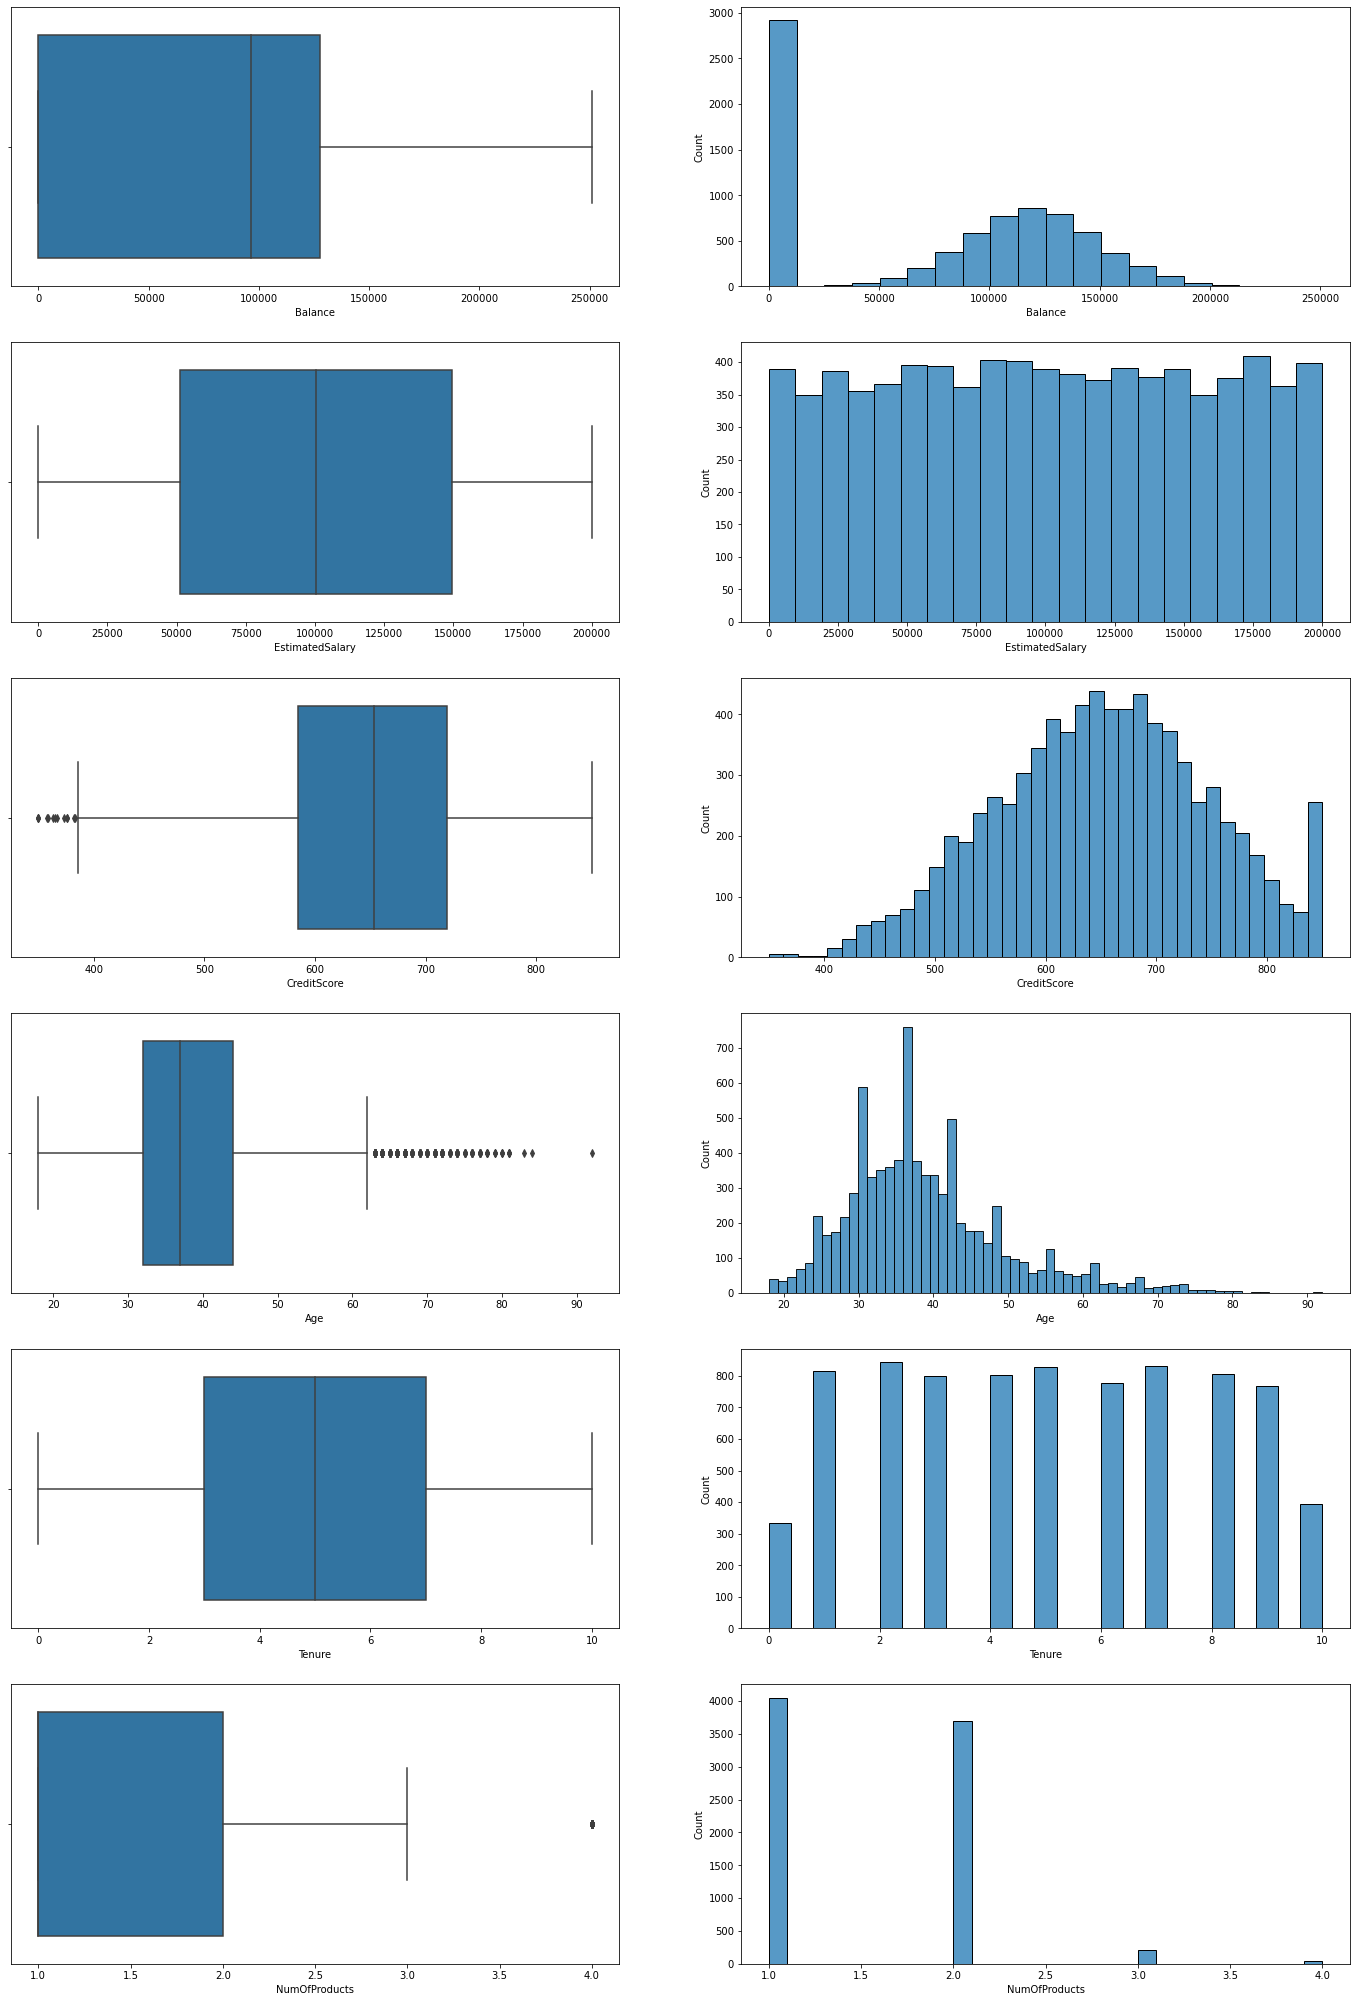

In [30]:
cols=continuous+discrete
fig, axes = plt.subplots(len(cols), 2, figsize=(24,6*len(cols)))
i=0
for var in continuous+discrete:
    sns.boxplot(ax=axes[i, 0],x=df2[var])
    sns.histplot(ax=axes[i, 1],data=df2, x=var)
    i+=1

### Categorical

**Analysis**
* 70% of clients have credit card
* 50% on France 25% on germany and 25% on Spain
* Active member and gender have distribution almost 50 by 50%

In [31]:
cat=df2[categorical].applymap(str)

In [32]:
# # plot number of categories per categorical variable
# cat.nunique().plot.bar(figsize=(10,6))
# plt.title('CARDINALITY: Number of categories in categorical variables')
# plt.xlabel('Categorical variables')
# plt.ylabel('Number of different categories')

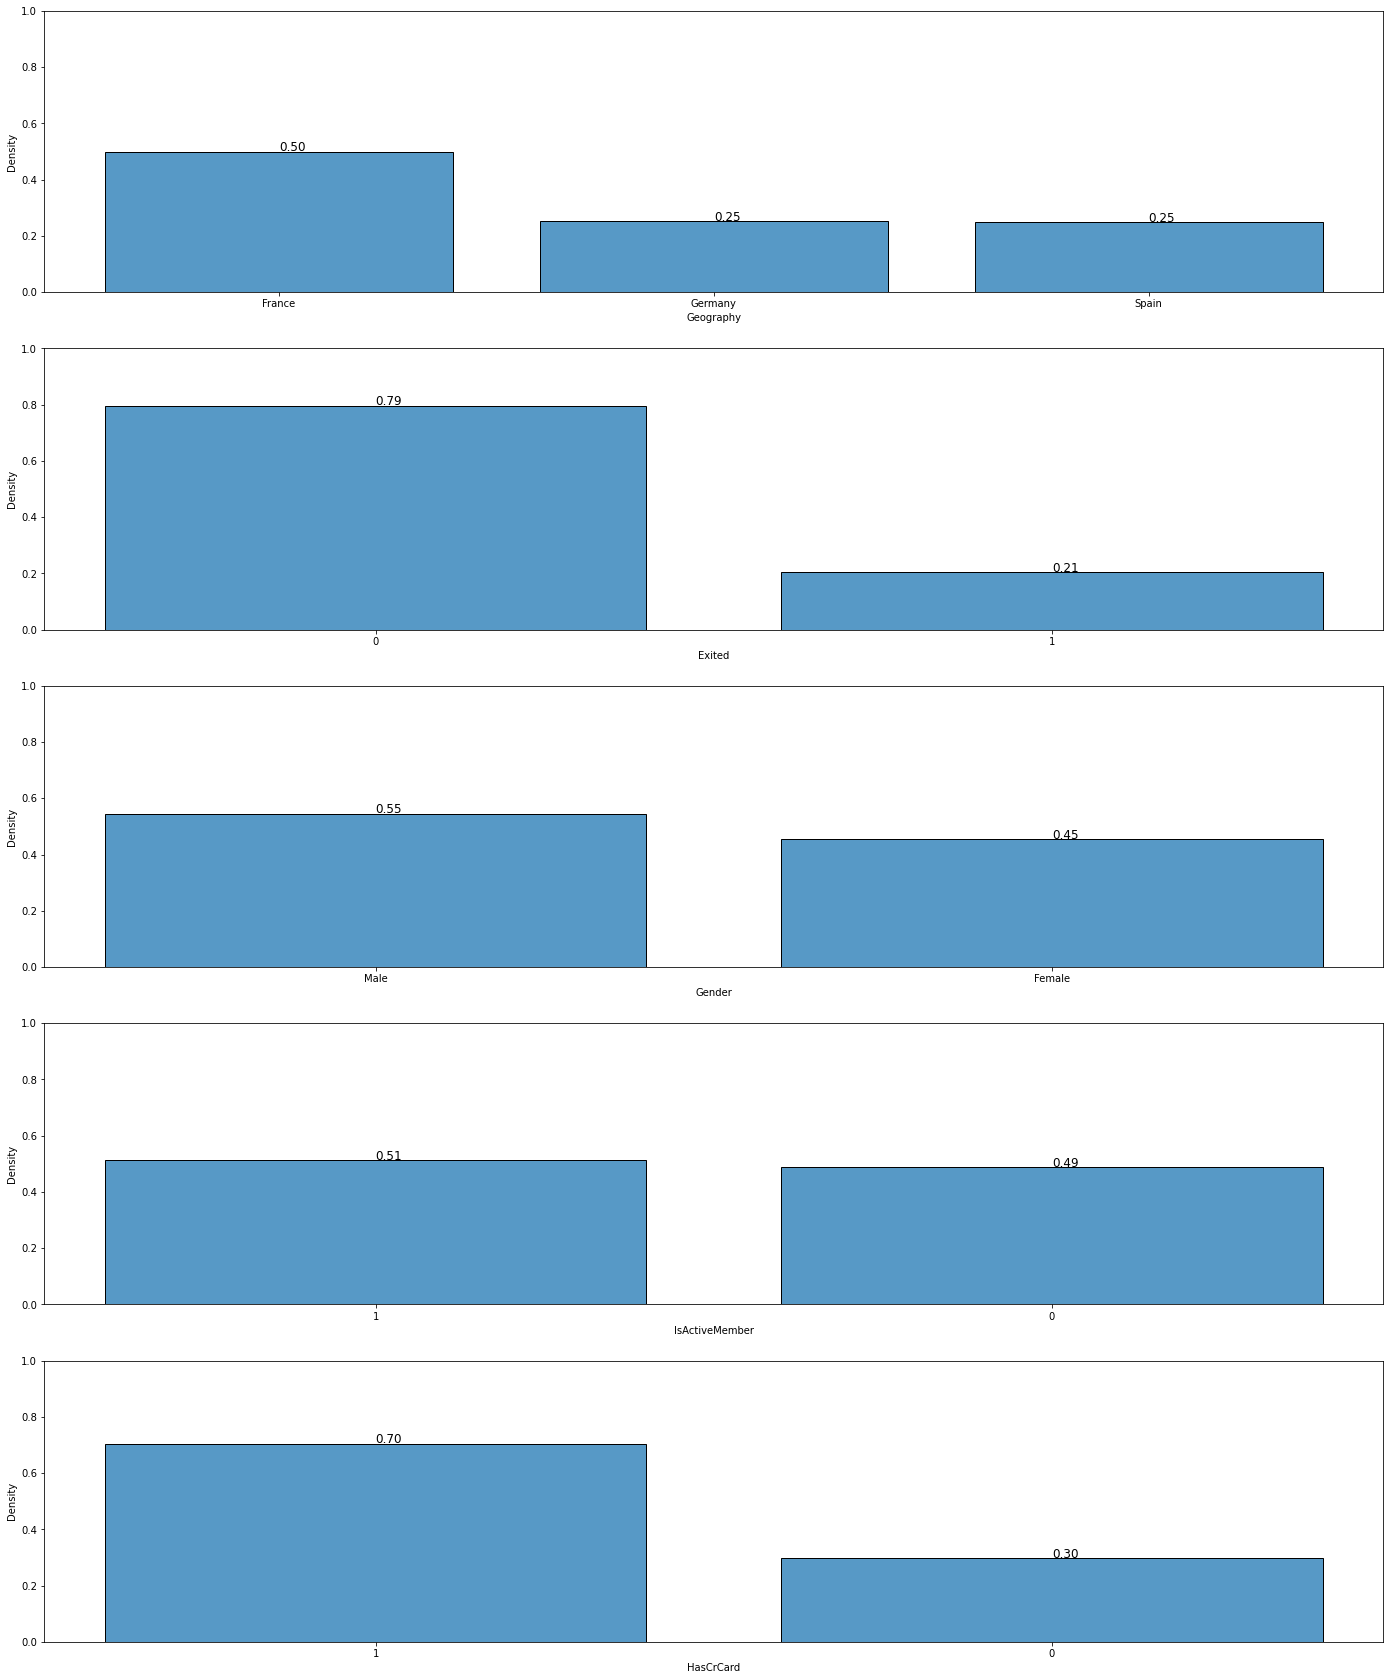

In [33]:
cols=categorical
fig, axes = plt.subplots(len(cols), 1, figsize=(24,6*len(cols)))
i=0
for var in categorical:
#     sns.boxplot(ax=axes[i, 0],x=df2[var])
    sns.histplot(ax=axes[i],data=cat, x=var, stat='density', shrink=.8)
    for p in axes[i].patches:
        axes[i].annotate(str(format(p.get_height(), '.2f')),(p.get_x()+p.get_width()/2.,p.get_height()*1.005),size=12)
    axes[i].set_ylim(0,1)
    i+=1

## Bivariate Analysis

### Continous + discrete

**Analysis**

A ratio of medians from positive response to negative response show that clients that have left the bank:
* Have balance 20% higher;
* 25% older in age;
* Bought only 1 product;
* Does not have lower salary, tenure or credit score;

In [34]:
df21=pd.concat([cat,df2[continuous+discrete]],axis=1)

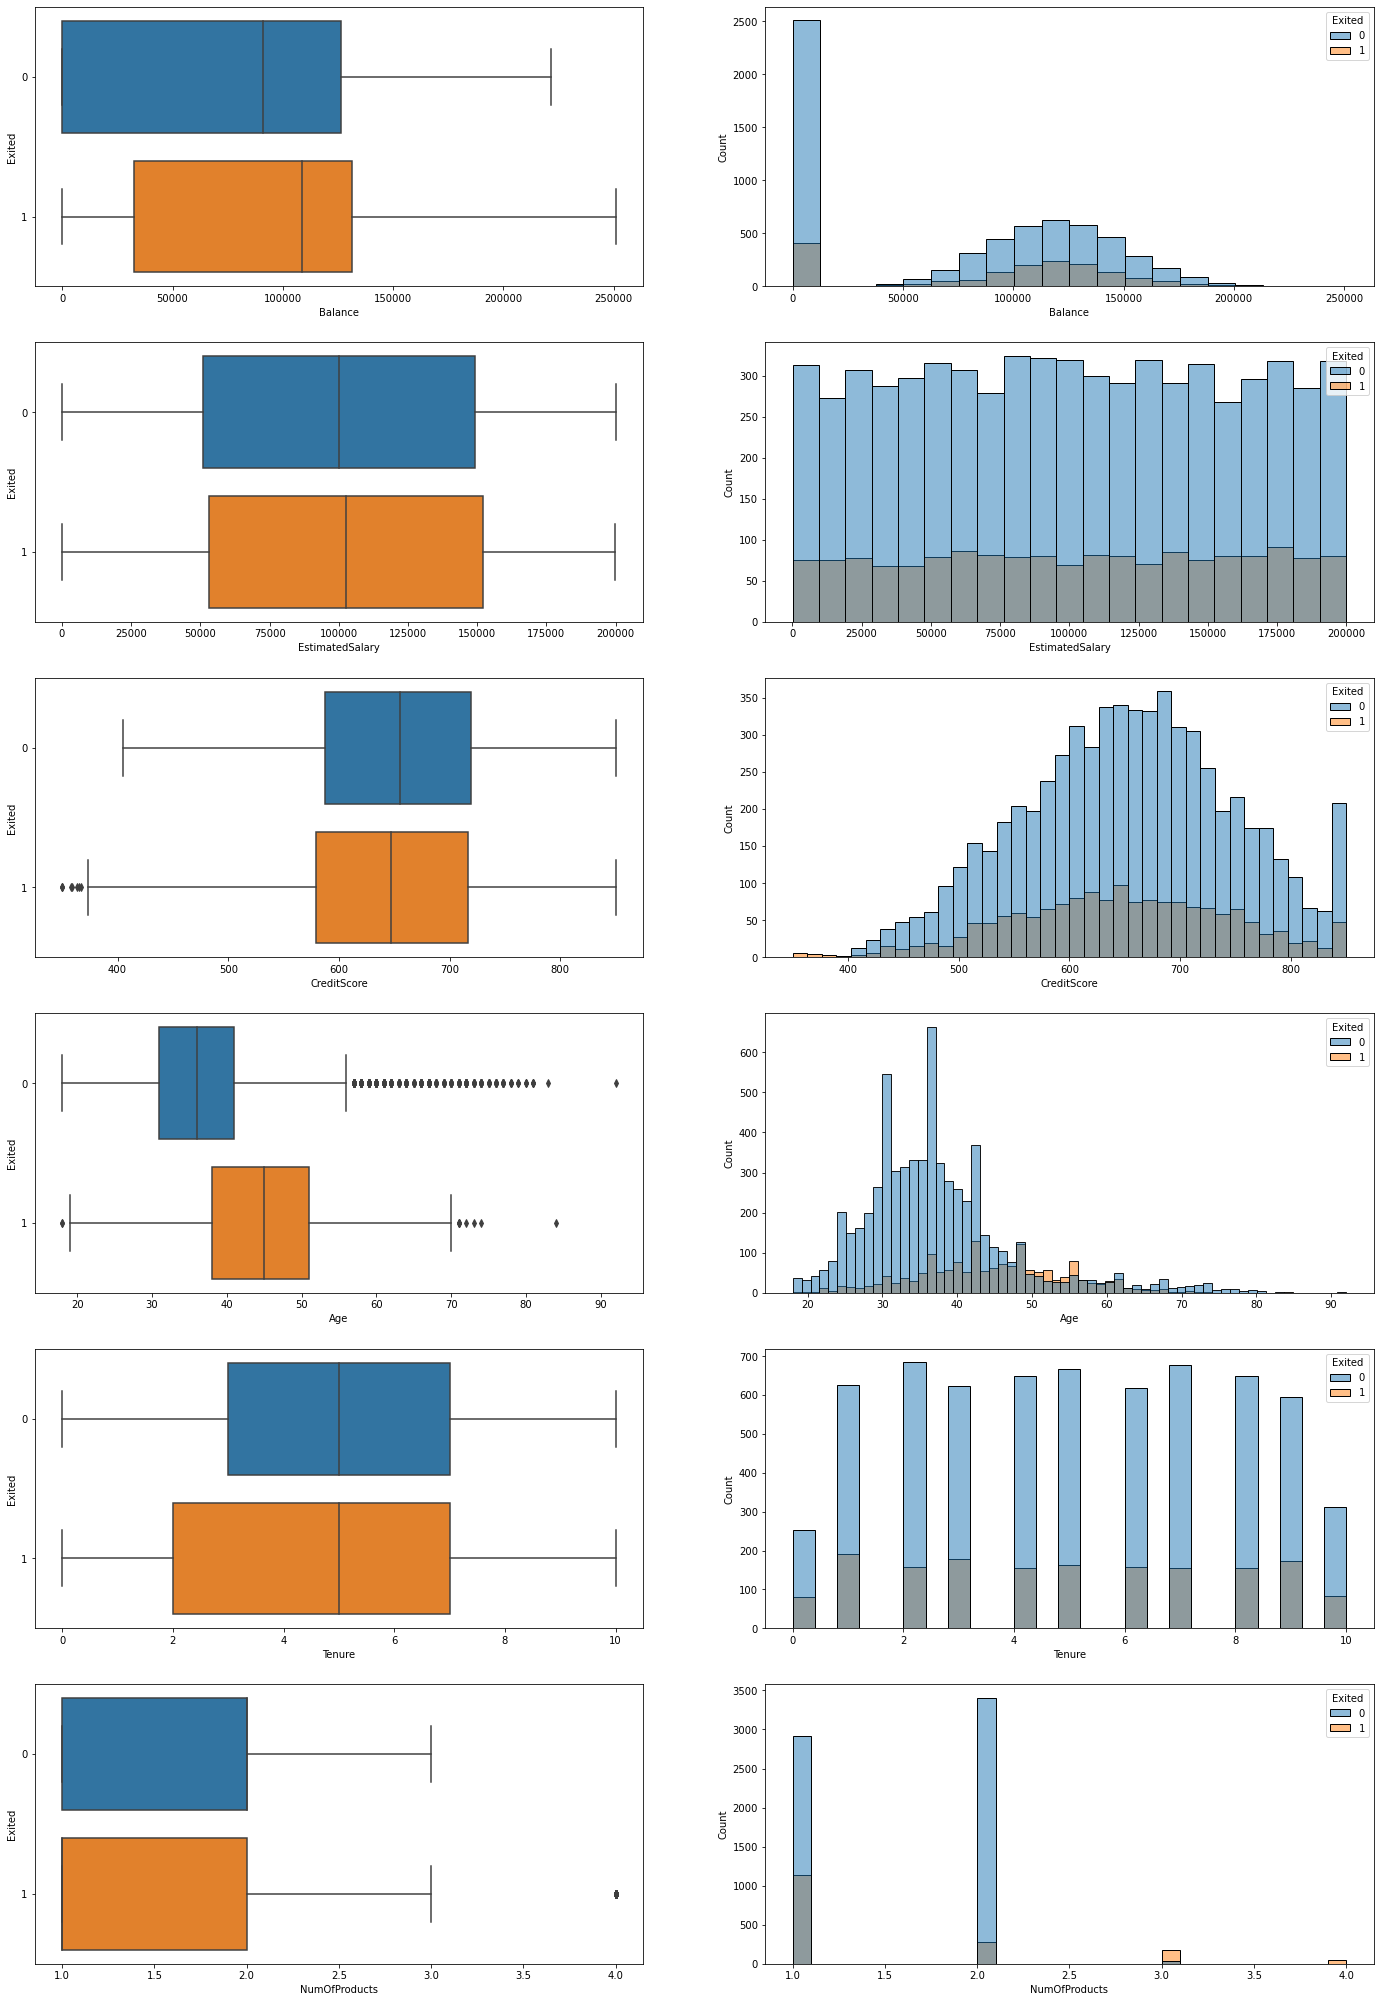

In [35]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

cols=continuous+discrete
fig, axes = plt.subplots(len(cols), 2, figsize=(24,6*len(cols)))
i=0
for var in continuous+discrete:
    sns.boxplot(ax=axes[i, 0], data=df21, x=var, y='Exited')
    sns.histplot(ax=axes[i, 1], data=df21, x=var, hue='Exited')
    i+=1

In [36]:
# lets separate between negative response and positive response
cont=df2[continuous+discrete]
cont_negative=cont[df2['Exited']==0]
cont_positive=cont[df2['Exited']==1]

In [37]:
# ratio of medians from positive response to negative response
ratio=cont_positive.median()/cont_negative.median()
ratio=ratio.apply(lambda x: round(x,2))

# A ratio of medians from positive response to negative response show that clients that have left the bank:
# Have balance 20% higher;
# doesn't have lower salary, tenure or credit score;
# 25% older in age;
# bought 50% less products;

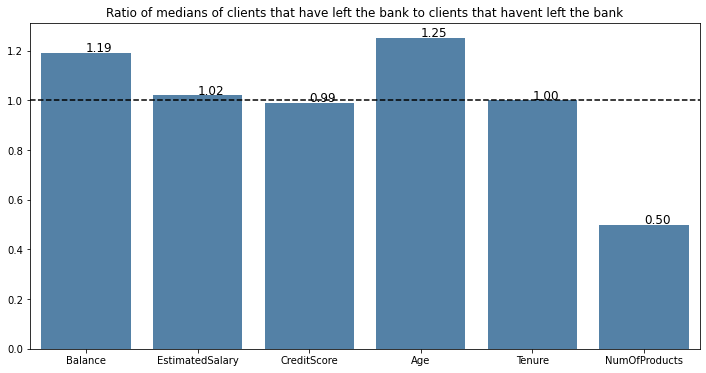

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Ratio of medians of clients that have left the bank to clients that havent left the bank')
sns.barplot(ax=ax,x=ratio.index, y=ratio.values, color='steelblue');
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.2f')),(p.get_x()+p.get_width()/2.,p.get_height()*1.005),size=12)
plt.axhline(y=1, color='k', linestyle='--')

### Categorical

**Analysis**

Probability higher of exiting bank than expected value for:
* German
* Female
* Not being an active member

Probability lower of exiting bank than expected value for:
* Males
* French
* Spanish
* Not being an active member

In [39]:
# target=cat.pop('Exited')

In [40]:
# lets separate between fraud and not fraud
cat_negative=cat[cat['Exited']=='0']
cat_positive=cat[cat['Exited']=='1']

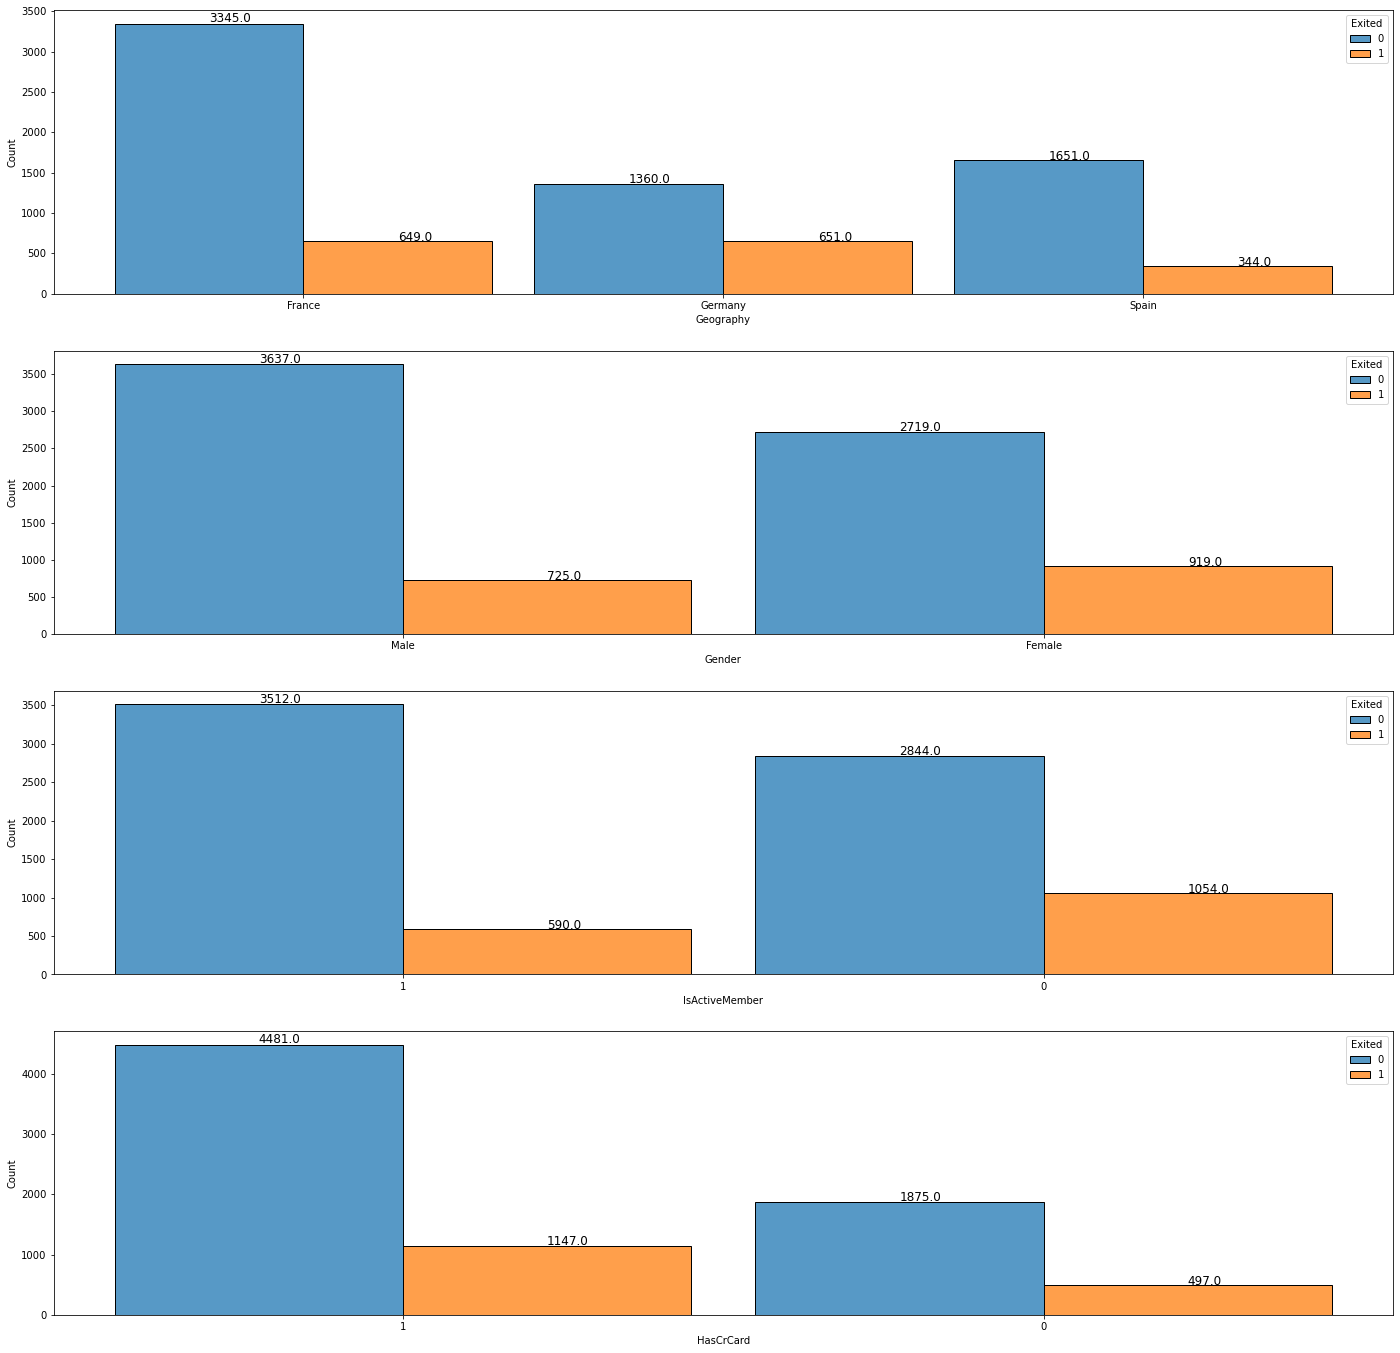

In [41]:
cols=categorical.copy()
cols.remove('Exited')
fig, axes = plt.subplots(len(cols), 1, figsize=(24,6*len(cols)))
i=0
for var in cols:
#     sns.boxplot(ax=axes[i, 0],x=df2[var])
    sns.histplot(ax=axes[i],data=df21, x=var, hue='Exited', stat='count', multiple="dodge", shrink=.9)
    for p in axes[i].patches:
        axes[i].annotate(str(format(p.get_height(), '.1f')),(p.get_x()+p.get_width()/2.,p.get_height()*1.005),size=12)
#     axes[i].set_ylim(0,1)
    i+=1

In [42]:
# Lets make a plot of the probability of Exited=1 for each categorical label
# first we need the probabilities from the contigency tables for each categorical variable
cols=categorical.copy()
cols.remove('Exited')
data=pd.Series()
for var in cols:
    aux=pd.crosstab(index=df2['Exited'],columns=df2[var],margins=False)
    aux=aux.loc[1]/(aux.loc[0]+aux.loc[1])
    data=pd.concat([data,aux])

C:\Users\marcellohro\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [43]:
# Now the index names need to be renamed
data.index

Index(['France', 'Germany', 'Spain', 'Female', 'Male', 0, 1, 0, 1], dtype='object')

In [44]:
cols

['Geography', 'Gender', 'IsActiveMember', 'HasCrCard']

In [45]:
data.index=['Female', 'Male', 'France', 'Germany', 'Spain','HasCrCard=0','HasCrCard=1','IsActiveMember=0','IsActiveMember=1']
data

Female              0.162494
Male                0.323720
France              0.172431
Germany             0.252611
Spain               0.166208
HasCrCard=0         0.270395
HasCrCard=1         0.143832
IsActiveMember=0    0.209528
IsActiveMember=1    0.203802
dtype: float64

In [46]:
# Exited=1 expected value
exp_val=df2['Exited'].value_counts(normalize=True).iloc[-1]
exp_val

0.2055

Probability higher of exiting bank than expected value for:
* French
* Female
* Not being an active member

Probability lower of exiting bank than expected value for:
* Males
* Not being an active member
* Germans

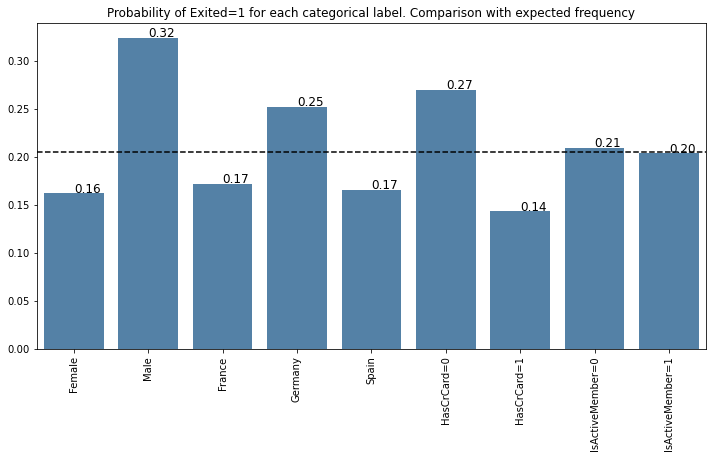

In [47]:
# this plot can be considered a summary of the contingency table for each variable
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Probability of Exited=1 for each categorical label. Comparison with expected frequency')
sns.barplot(ax=ax,x=data.index, y=data.values, color='steelblue');
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.2f')),(p.get_x()+p.get_width()/2.,p.get_height()*1.005),size=12)
plt.axhline(y=exp_val, color='k', linestyle='--')
plt.xticks(rotation=90);

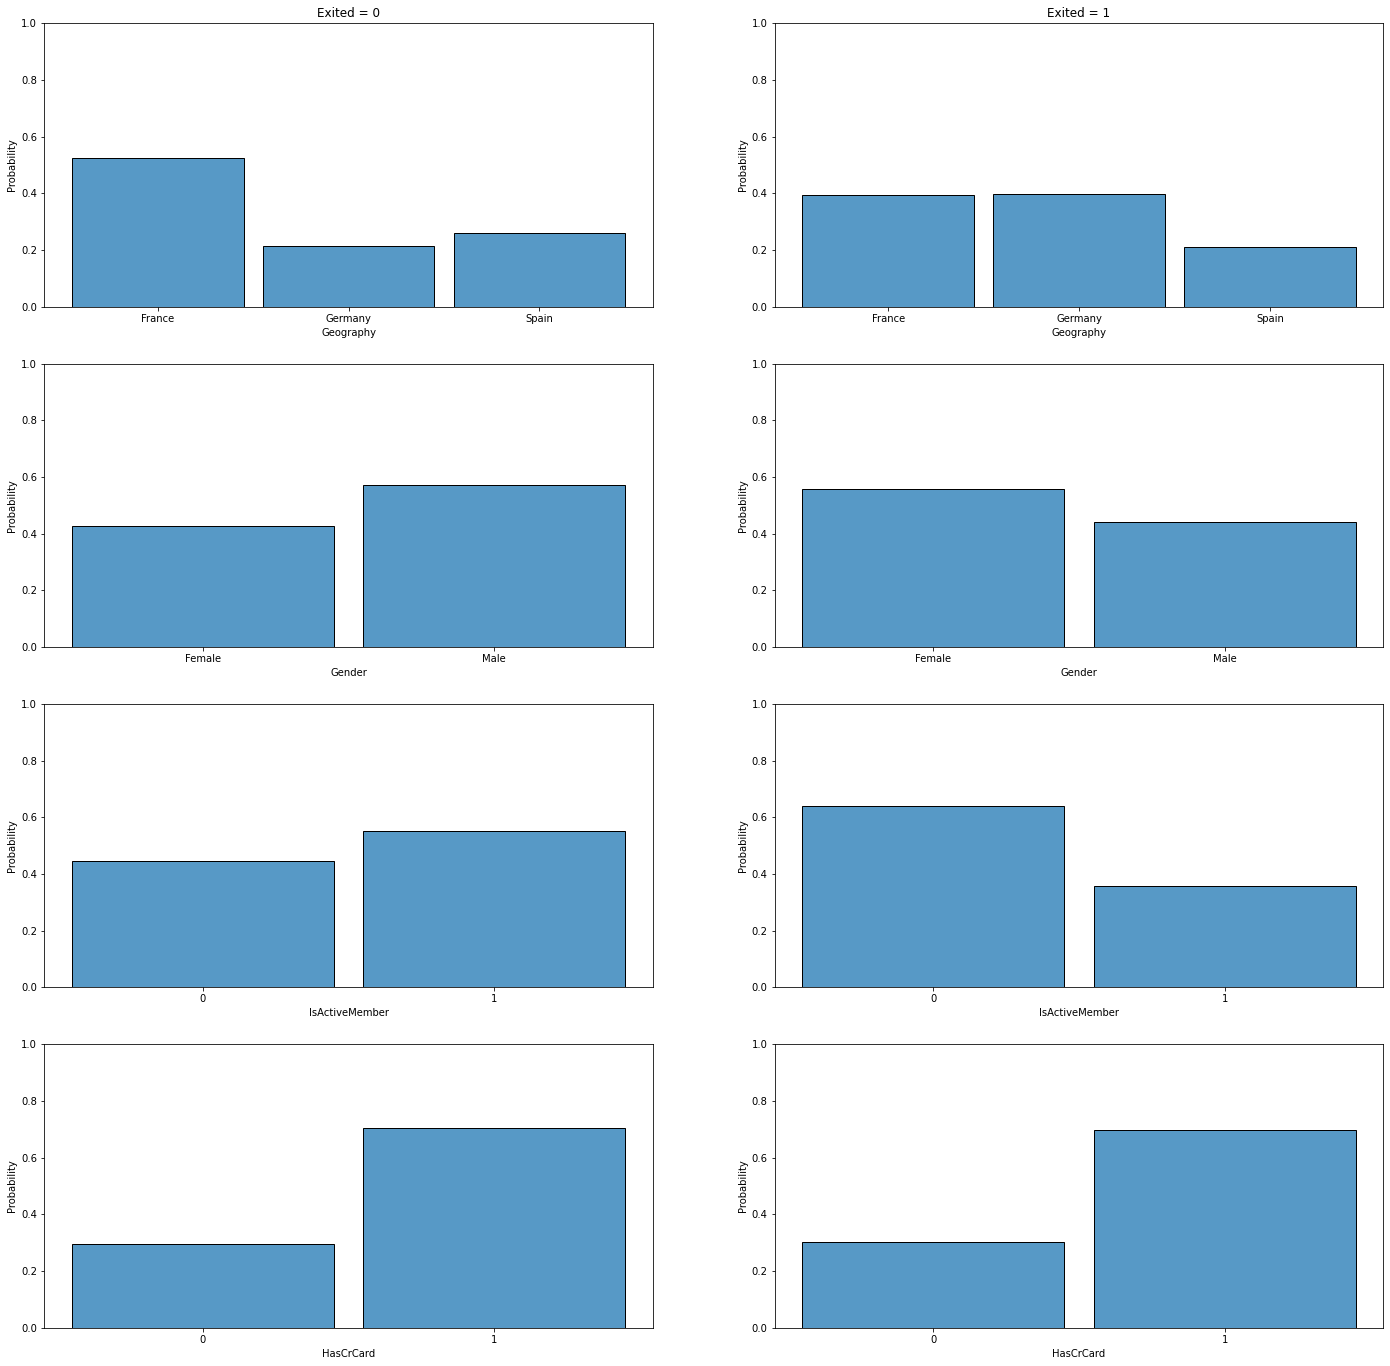

In [48]:
# variables probabilities given target label
cols=categorical.copy()
cols.remove('Exited')
fig, axes = plt.subplots(len(cols), 2, figsize=(24,6*len(cols)))

axes[0,0].set_title('Exited = 0')
axes[0,1].set_title('Exited = 1')

i=0
for var in cols:
    sns.histplot(ax=axes[i, 0], data=cat_negative.sort_values(by=categorical), x=var, stat='probability', shrink=0.9)
    axes[i, 0].set_ylim(0,1)
    sns.histplot(ax=axes[i, 1], data=cat_positive.sort_values(by=categorical), x=var, stat='probability', shrink=0.9)
    axes[i, 1].set_ylim(0,1)
    i+=1

## Mulvatiate correlation analysis

### Pearson correlation

<AxesSubplot:>

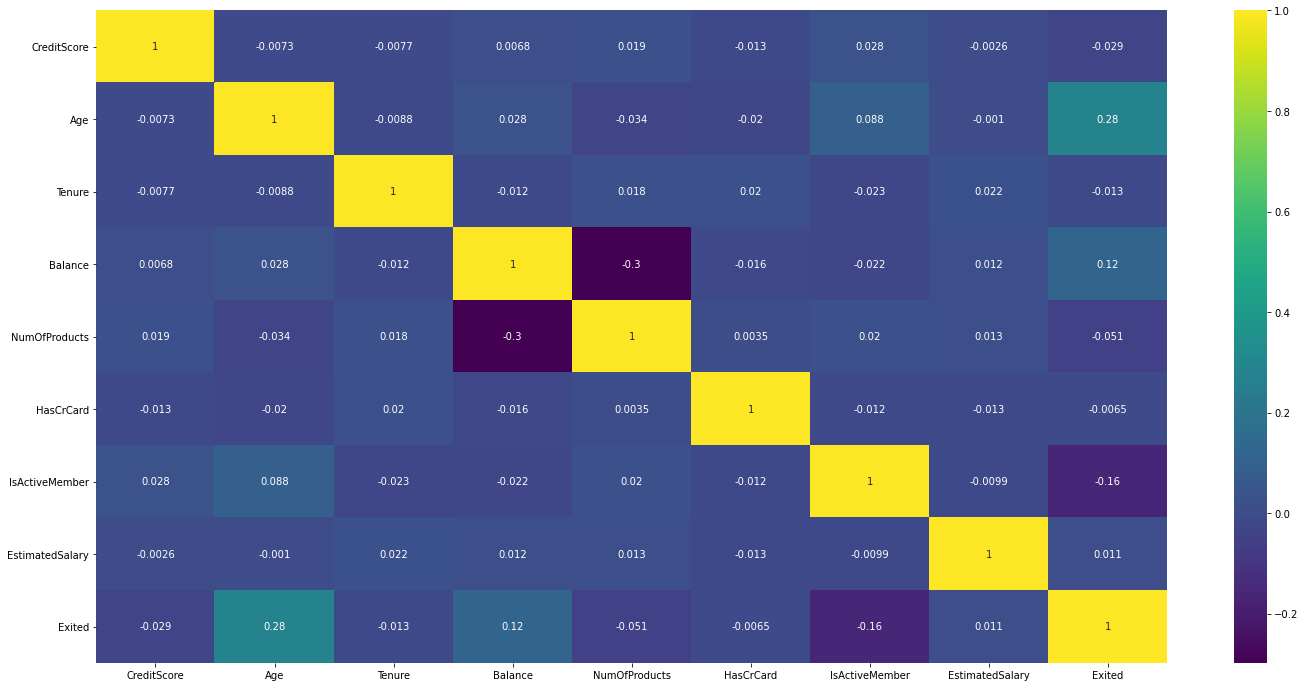

In [49]:
plt.figure(figsize=(24,12))
sns.heatmap(df2.corr(method='pearson'),cmap='viridis',annot=True)

### Cramer-v categorical correlation

In [50]:
aux=df2[categorical].applymap(str)

In [51]:
cat_attributes_list = aux.columns

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( aux[ ref ], aux[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

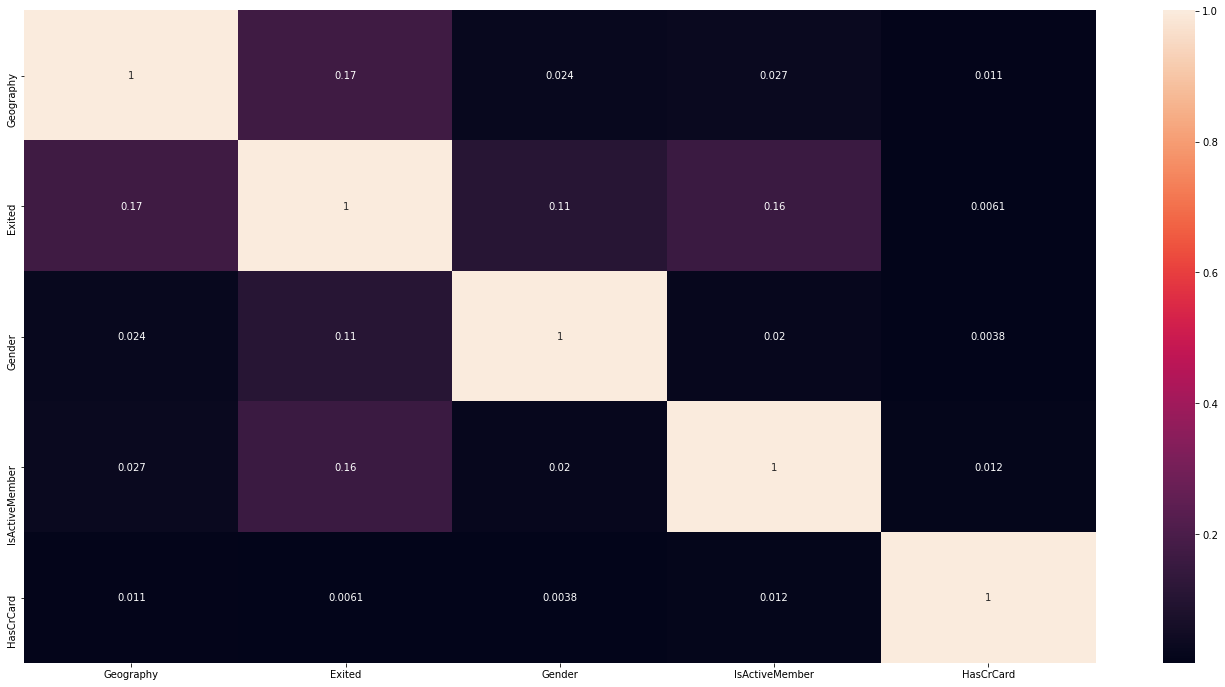

In [52]:
plt.figure(figsize=(24,12))
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# DATA PREPARATION

In [53]:
df3=df2.copy()

In [54]:
discrete,continuous,categorical,dates=variable_types(df3)

There are 4 discrete variables
There are 2 continuous variables
There are 5 categorical variables
There are 0 date_time variables


## Categorical

In [55]:
df3[categorical].dtypes

Geography         object
Exited             int64
Gender            object
IsActiveMember     int64
HasCrCard          int64
dtype: object

In [56]:
df3['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [57]:
# use one hot-encoding for gender
dic={'Male':0,'Female':1}
df3['Gender']=df3['Gender'].map(dic)

In [58]:
df3['Geography'].unique()

array(['France', 'Germany', 'Spain'], dtype=object)

In [59]:
# use ordered target encoding for geography
dic={'Germany':0,'Spain':1,'France':2}
df3['Geography']=df3['Geography'].map(dic)

In [60]:
df3[discrete].dtypes

CreditScore      int64
Age              int64
Tenure           int64
NumOfProducts    int64
dtype: object

## Continuous

### Outliers study

**Analysis**

No extreme outliers on data

In [61]:
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
#     upper_boundary = df[variable].mean() + distance * df[variable].std()
#     lower_boundary = df[variable].mean() - distance * df[variable].std()
#     lower_boundary = df[variable].quantile(0.05)
#     upper_boundary = df[variable].quantile(0.95)
    return upper_boundary, lower_boundary

In [62]:
for var in continuous+discrete:
    RM_upper_limit, RM_lower_limit = find_skewed_boundaries(df3, var, 3)
    print(var,' Upper limit :',RM_upper_limit)
    print('Outliers: ')
    print(df3[df3[var]>RM_upper_limit][var].values,'\n')
    # drop outliers
    df3=df3.loc[df3[var]<=RM_upper_limit]

Balance  Upper limit : 510445.33
Outliers: 
[] 

EstimatedSalary  Upper limit : 444290.995
Outliers: 
[] 

CreditScore  Upper limit : 1121.0
Outliers: 
[] 

Age  Upper limit : 80.0
Outliers: 
[83 92 81 84 81 81 81] 

Tenure  Upper limit : 19.0
Outliers: 
[] 

NumOfProducts  Upper limit : 5.0
Outliers: 
[] 



### Scaling study

In [63]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    plt.title(variable)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    ss.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

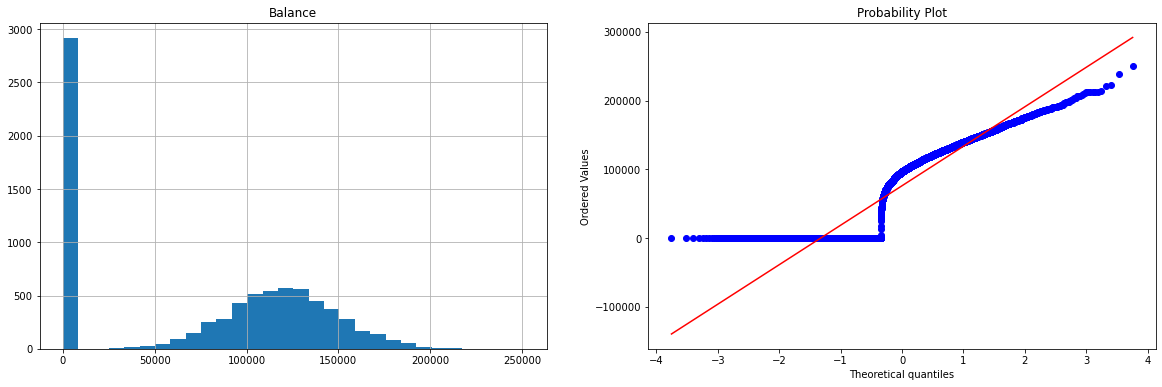

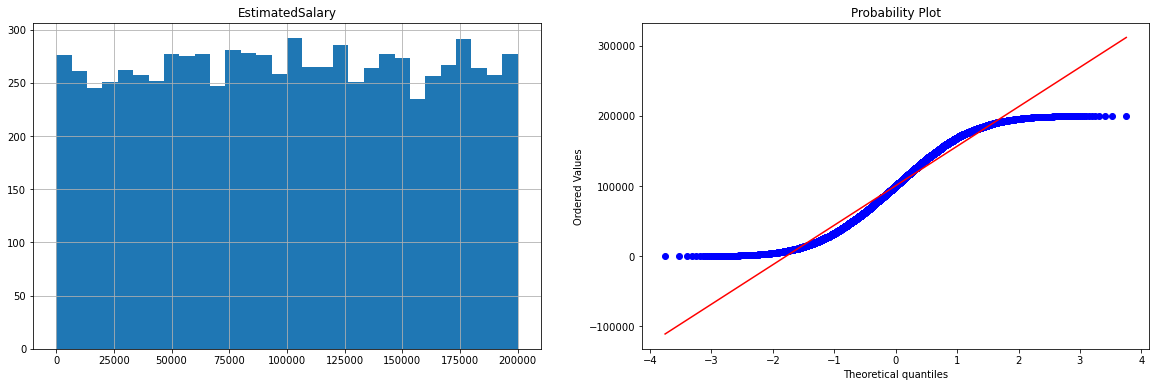

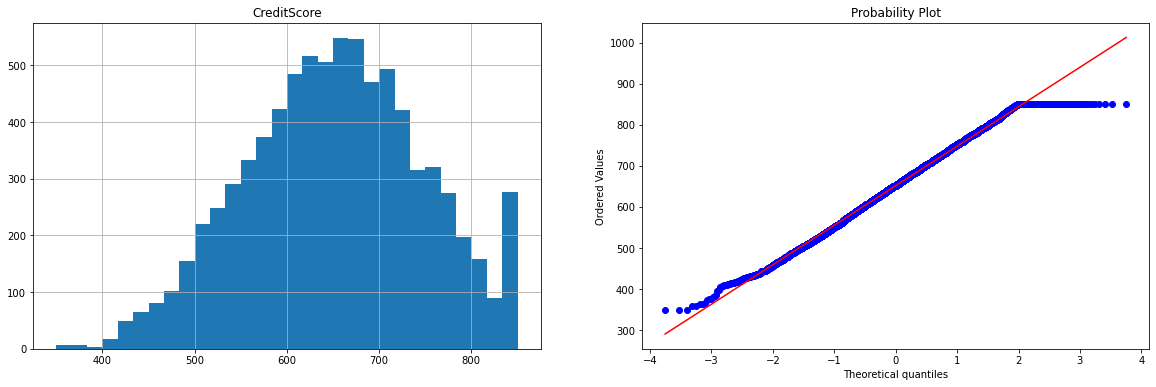

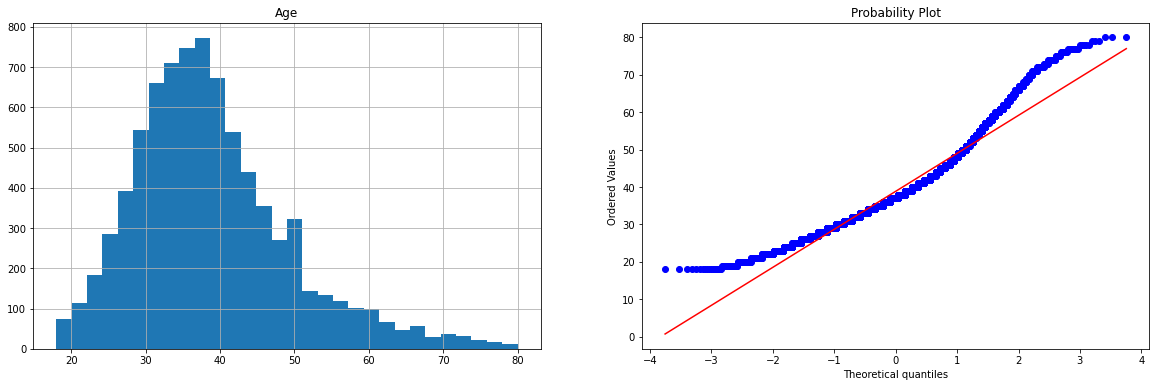

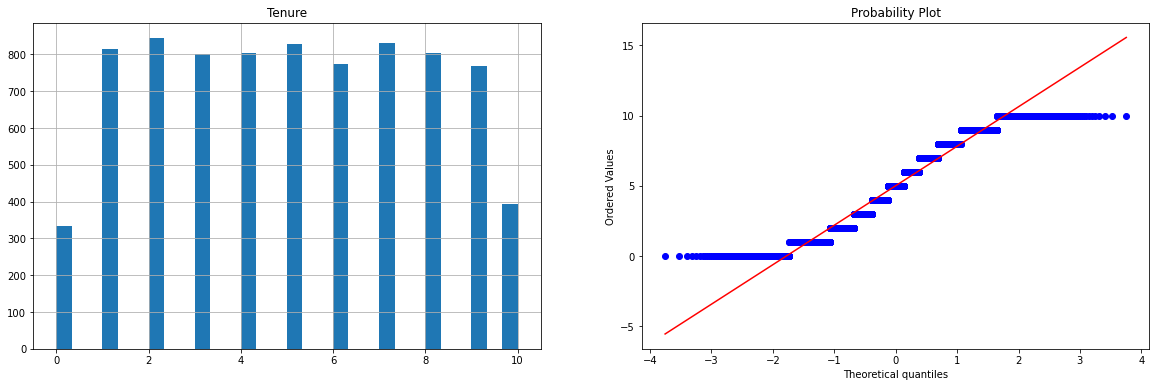

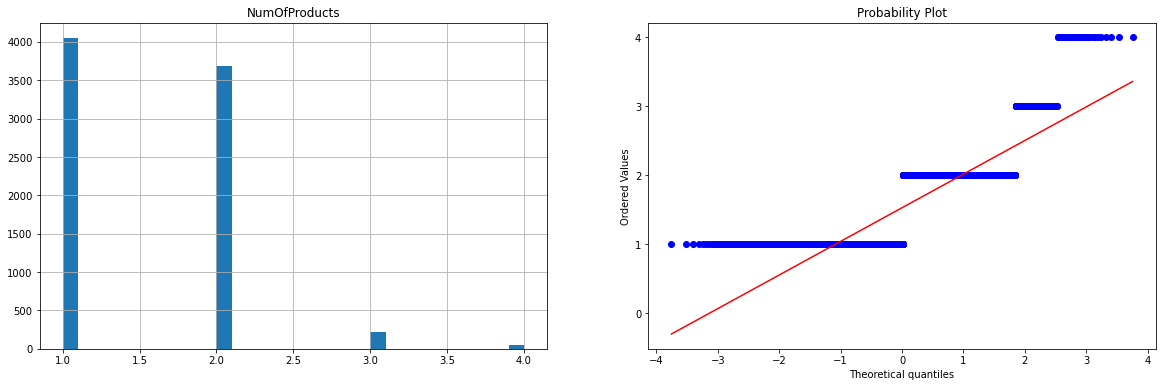

In [64]:
# acessing normality of nonscaled
for var in continuous+discrete:
    diagnostic_plots(df3, var)

 scale:  [127631.62]


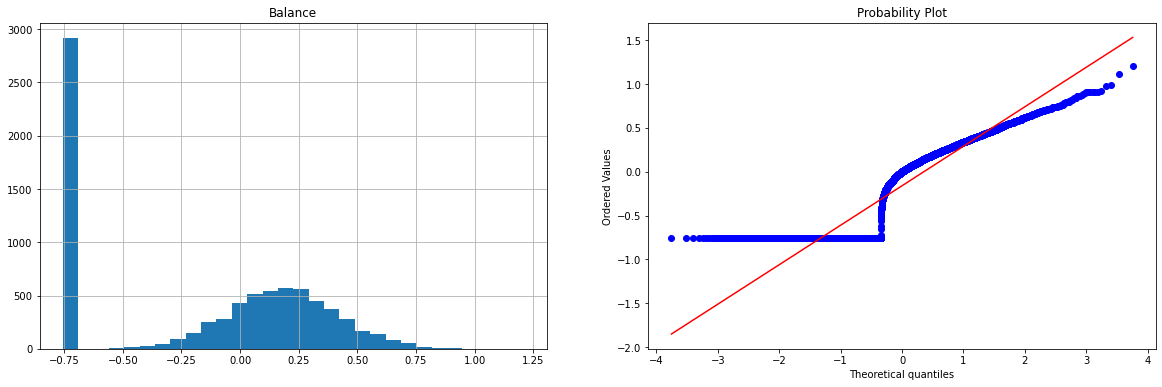

 scale:  [98229.05]


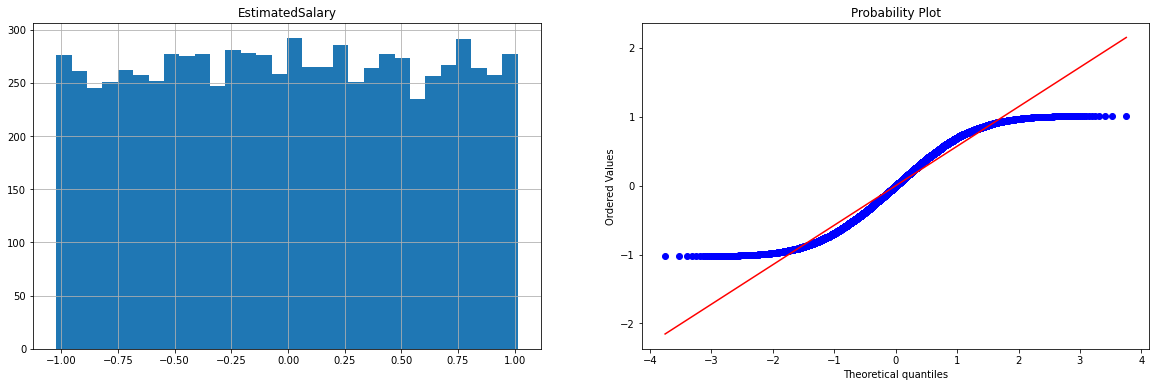

 scale:  [133.]


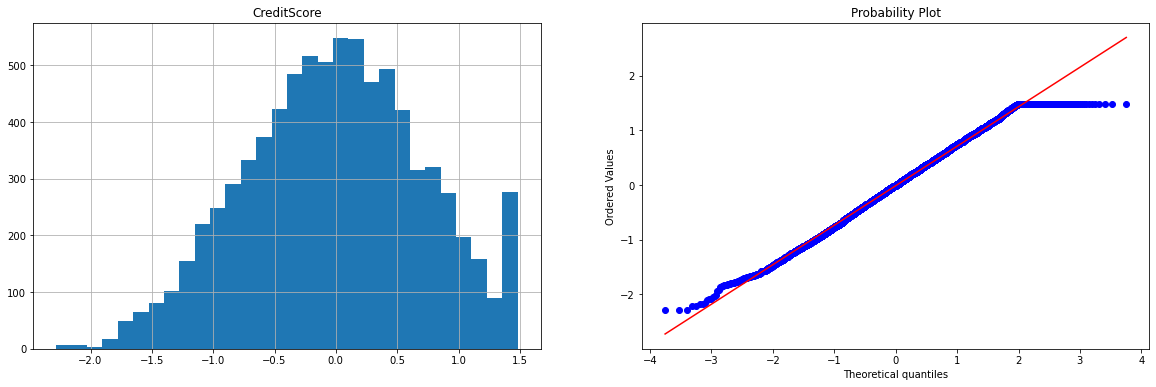

 scale:  [12.]


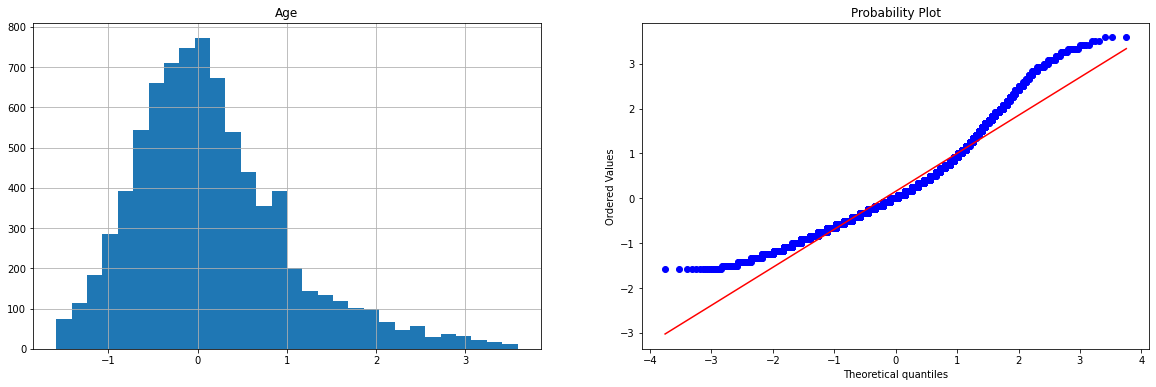

 scale:  [4.]


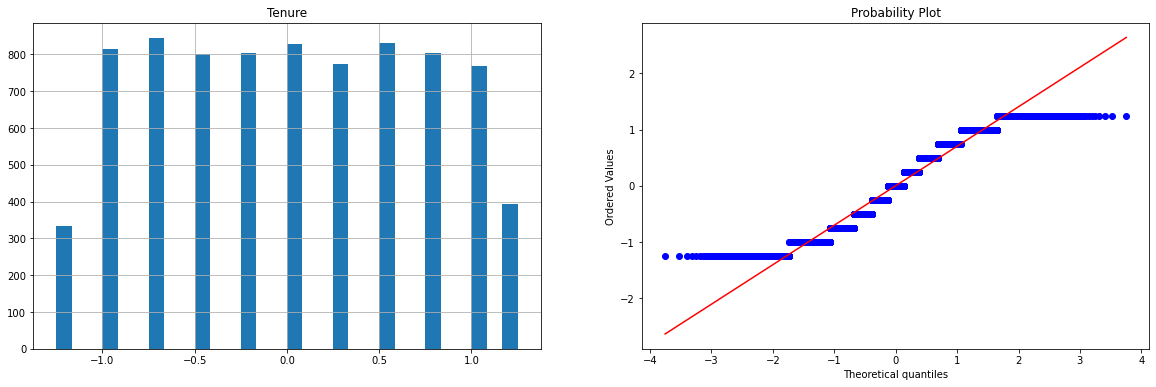

 scale:  [1.]


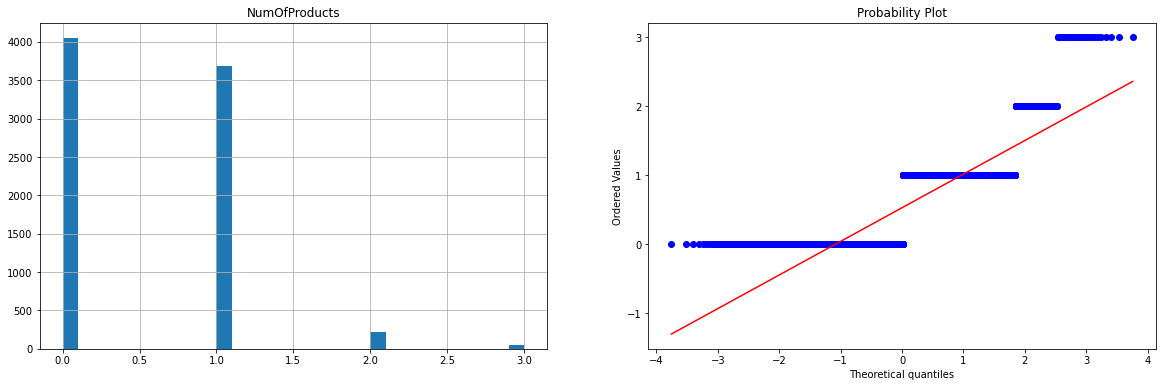

In [65]:
# studying viability of robustscaler
aux=df3.copy()
scaler = RobustScaler()
for var in continuous+discrete:
    aux[[var]]=scaler.fit_transform(aux[[var]].values)
    print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

 scale:  [62460.49487183]


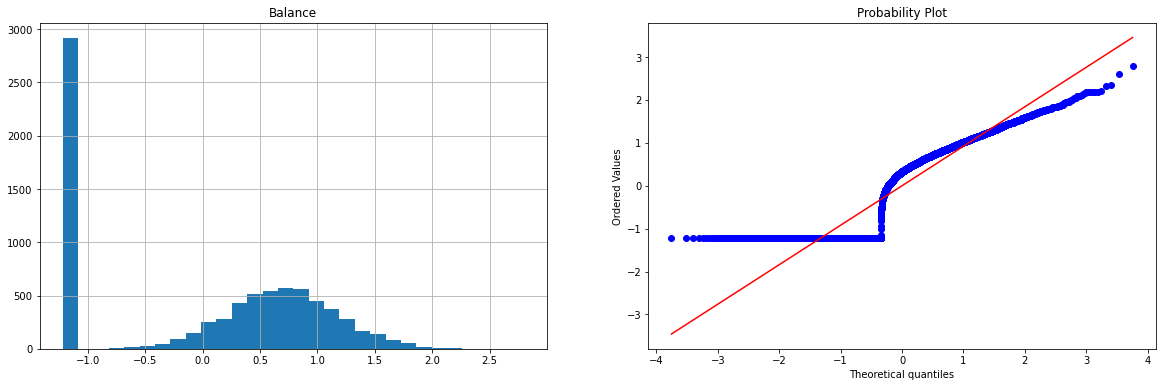

 scale:  [57513.45153872]


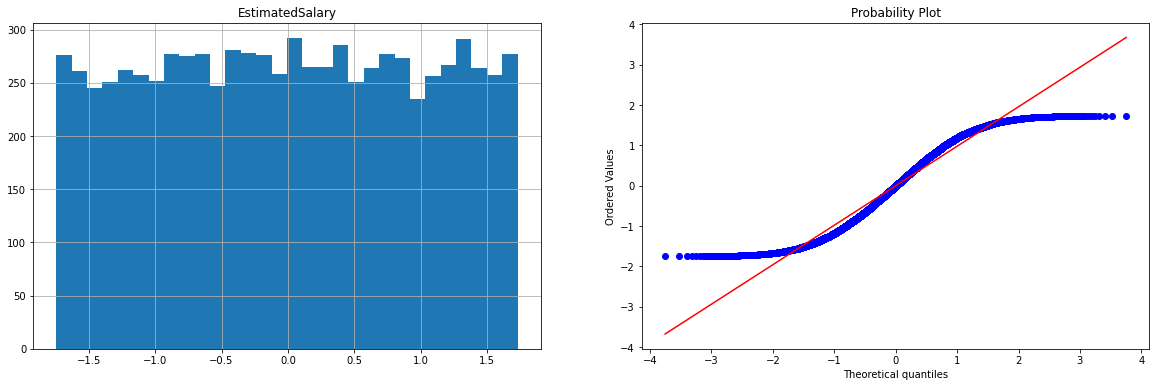

 scale:  [96.30271917]


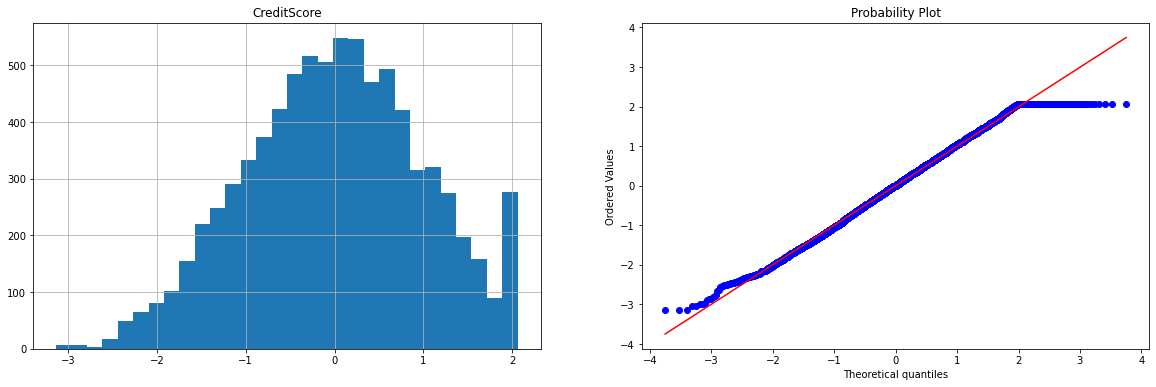

 scale:  [10.4399339]


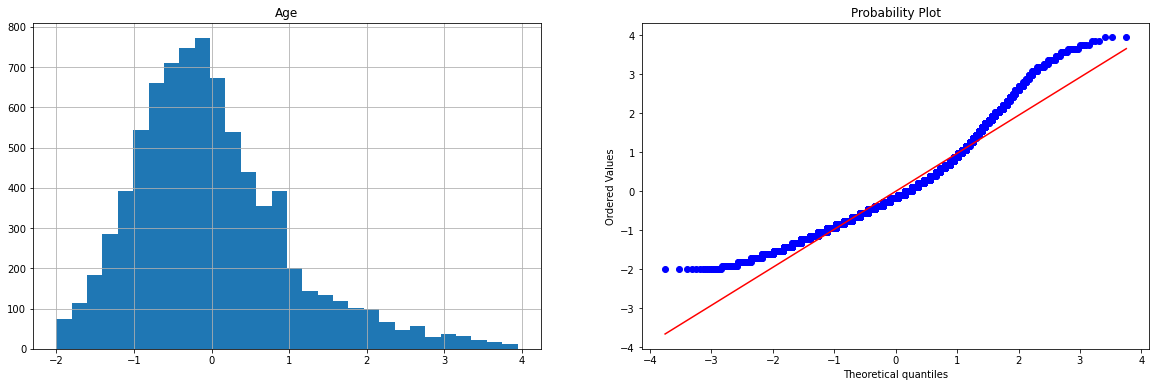

 scale:  [2.882209]


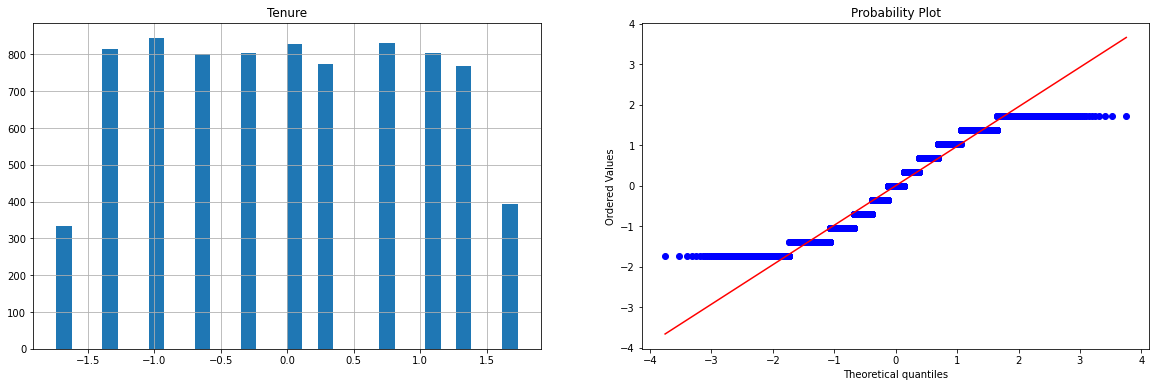

 scale:  [0.57972937]


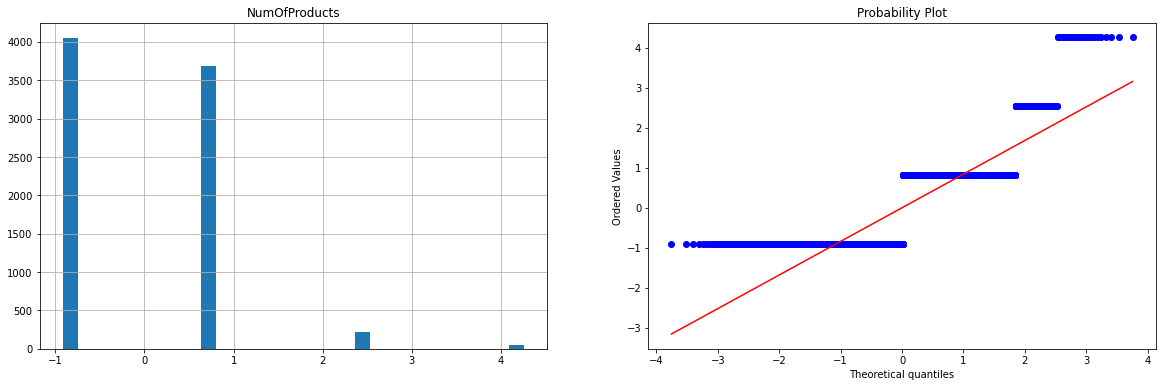

In [66]:
# studying viability of standardscaler
aux=df3.copy()
scaler = StandardScaler()
for var in continuous+discrete:
    aux[[var]]=scaler.fit_transform(aux[[var]].values)
    print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

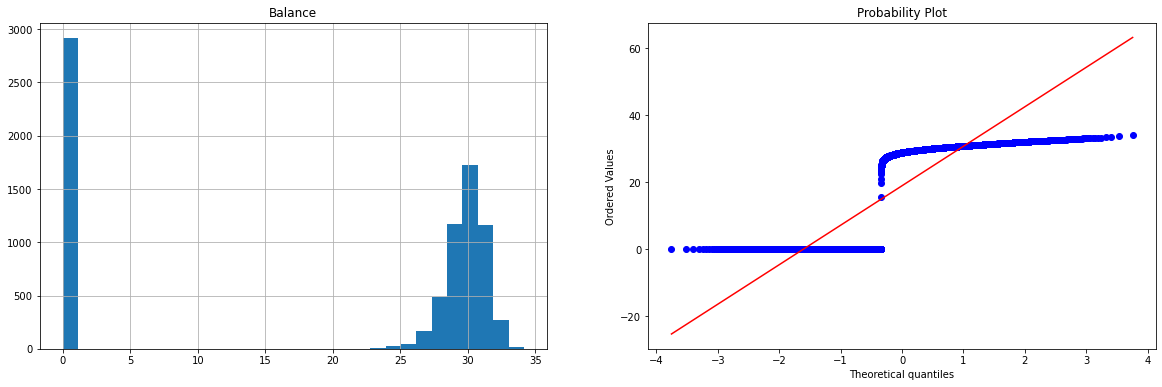

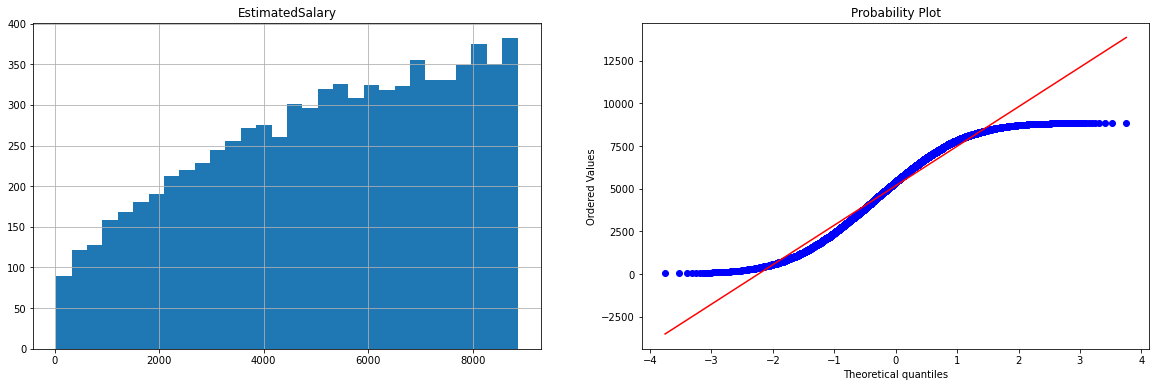

In [67]:
# studying viability of robustscaler
aux=df3.copy()
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
for var in continuous:
    aux[[var]]=transformer.fit_transform(aux[[var]].values)
#     print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

### Robust scaling continuous and discrete variables

In [68]:
aux=df3.copy()
cols=continuous+discrete

In [69]:
scaler = RobustScaler()
cols=continuous+discrete
df3[cols]=scaler.fit_transform(df3[cols].values)

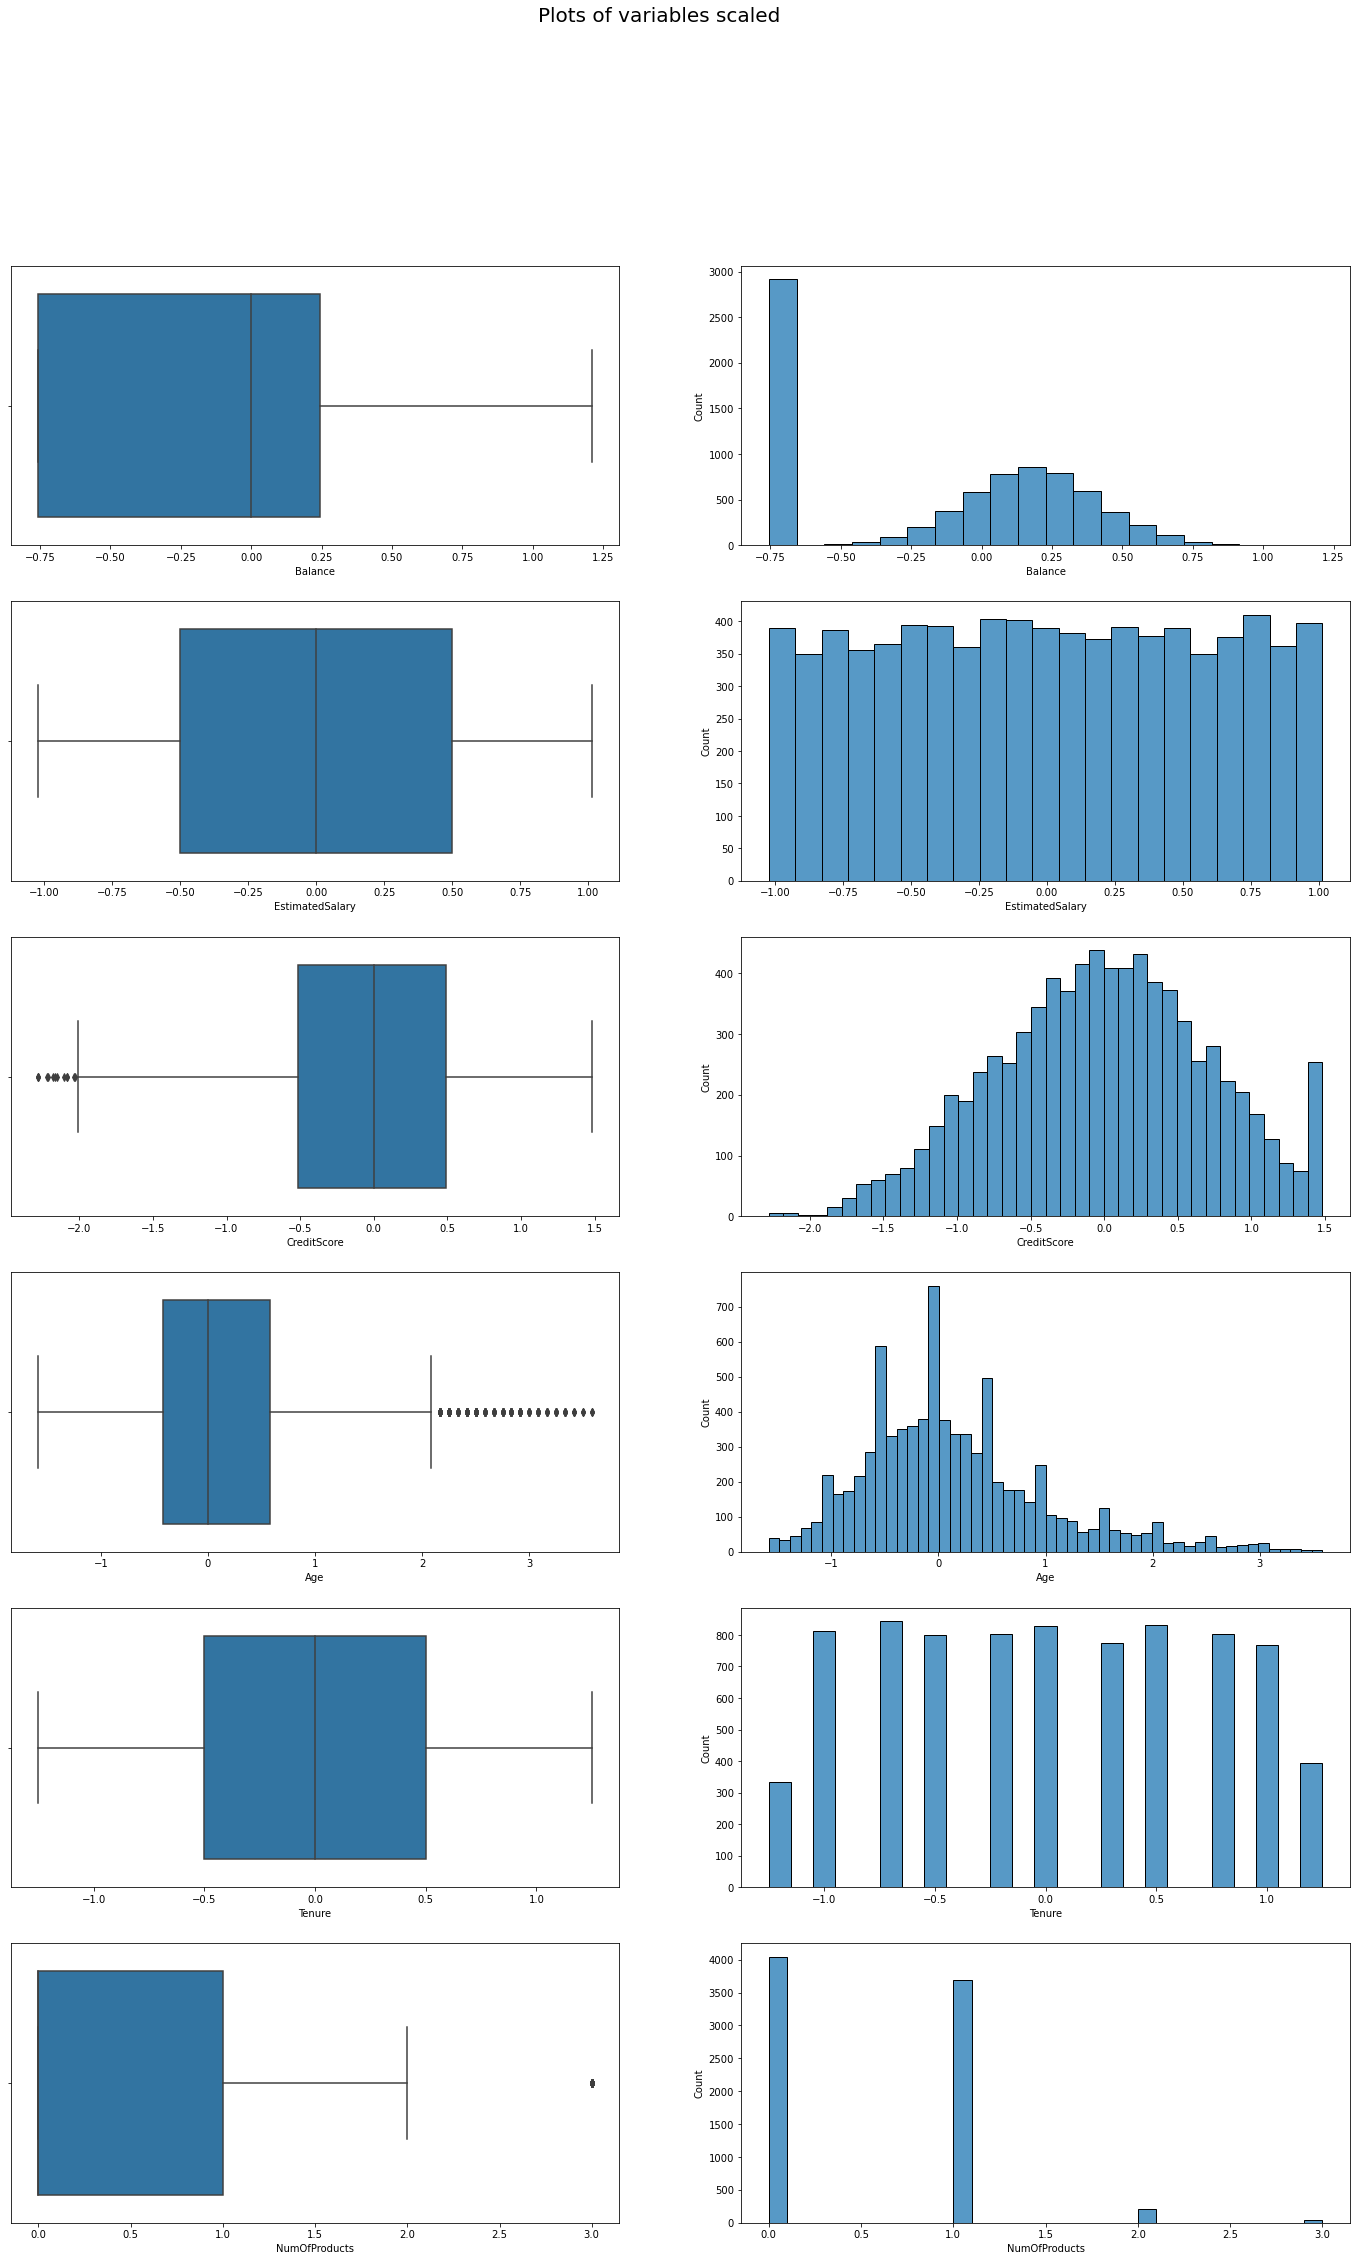

In [70]:
cols=continuous+discrete
fig, axes = plt.subplots(len(cols), 2, figsize=(24,6*len(cols)))
fig.suptitle('Plots of variables scaled', fontsize=20)
i=0
for var in continuous+discrete:
    sns.boxplot(ax=axes[i, 0],x=df3[var])
    sns.histplot(ax=axes[i, 1],data=df3, x=var)
    i+=1


In [71]:
# Variables ranges are consistent
(df3.max() - df3.min())

CreditScore        3.759398
Geography          2.000000
Gender             1.000000
Age                5.166667
Tenure             2.500000
Balance            1.965799
NumOfProducts      3.000000
HasCrCard          1.000000
IsActiveMember     1.000000
EstimatedSalary    2.034843
Exited             1.000000
dtype: float64

# FEATURE SELECTION
**Analysis**

Final columns selected are consistent with correlation analysis of section 2.6:

['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember','EstimatedSalary']

In [72]:
df4=df3.copy()

In [73]:
# X and y for feature importance testing
X = df4.drop(['Exited'],axis=1).values
y = df4['Exited'].values.ravel()

In [74]:
# # define RandomForestRegressor
# rf = RandomForestClassifier(max_depth=5, n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators=60, verbose=0, random_state=SEED ).fit( X, y )

In [75]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_fs = df4.drop(['Exited'],axis=1)
# cols_selected_boruta = X_fs.iloc[:, cols_selected].columns.to_list()
# print('cols selected: ',cols_selected_boruta)
# print('')
# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_fs.columns, cols_selected_boruta ) )
# print('cols not selected: ',cols_not_selected_boruta)

In [76]:
# cols_selected = boruta.support_weak_.tolist()

# # best features
# X_fs = df4.drop(['Exited'],axis=1)
# cols_selected_boruta = X_fs.iloc[:, cols_selected].columns.to_list()
# print('cols selected: ',cols_selected_boruta)
# print('')
# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_fs.columns, cols_selected_boruta ) )
# print('cols not selected: ',cols_not_selected_boruta)

In [77]:
# rank = boruta.ranking_.tolist()
# cols=df4.drop(['Exited'],axis=1).columns.to_list()
# pd.DataFrame({'rank': rank, 'cols': cols})

Final columns selected:

['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember','EstimatedSalary']

In [78]:
# Final columns selected for Machine Learning
cols_selected=['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember','EstimatedSalary']

# MACHINE LEARNING MODEL SELECTION

In [79]:
target=['Exited']

In [80]:
df5=df4[cols_selected+target]

## Baseline

random choice

In [81]:
# Split dataset into training and test
X=df5.drop(target,axis=1)
y=df5[target]
x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.2, random_state=SEED )

In [82]:
response_weights=df5[target].value_counts( normalize=True ).sort_index().tolist()
k_num = y_validation.shape[0]
yhat_random = random.choices( population=[0, 1],  
                              weights=response_weights,
                              k=k_num )

  Model Name    Recall  Balanced accuracy  F1 score  Kappa Metrics
0     random  0.173252           0.490169  0.180666      -0.020278 



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

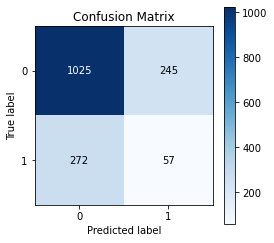

In [83]:
print( ml_error('random',y_validation,yhat_random), '\n' )

# # Classification report
# print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_validation, yhat_random, normalize=False, figsize=(4,4))

## Testing ML models

Best model is Random forest with oversampling. Neural network has the highest standard deviation on cross-validation

### Without oversampling

In [84]:
gaus = GaussianNB()
gaus_cv = cross_validation( target, df5, 5, 'Naive-Bayes', gaus)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN3_cv = cross_validation( target, df5, 5, 'KNN-3', KNN)
KNN = KNeighborsClassifier(n_neighbors=9)
KNN9_cv = cross_validation( target, df5, 5, 'KNN-9', KNN)
KNN = KNeighborsClassifier(n_neighbors=15)
KNN_cv = cross_validation( target, df5, 5, 'KNN-15', KNN)
lg = LogisticRegression()
lg_cv = cross_validation( target, df5, 5, 'Logistic Regression', lg)
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df5, 5, 'Decision Tree', dtc)
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df5, 5, 'Random Forest', rfc)
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df5, 5, 'XGBoost', xgbc)
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df5, 5, 'SVM_linear', svm)
svm = SVC()
svm_cv_rbf = cross_validation( target, df5, 5, 'SVM_rbf', svm)

In [188]:
model = ml.Sequential()
NN_cv = cross_validation( target, df5, 5, 'Neural Net', model)

Epoch 00029: early stopping
Epoch 00024: early stopping
Epoch 00007: early stopping
Epoch 00007: early stopping
Epoch 00011: early stopping


In [189]:
#winner: Neural net
modelling_result_cv = pd.concat( [
    gaus_cv,
    KNN3_cv,
    KNN9_cv,
    KNN_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,Naive-Bayes,0.83 +/- 0.0053,0.6327 +/- 0.0092,0.4183 +/- 0.0207,0.3375 +/- 0.0218
0,KNN-3,0.8415 +/- 0.0062,0.6961 +/- 0.0109,0.5379 +/- 0.0189,0.4468 +/- 0.0213
0,KNN-9,0.8457 +/- 0.0077,0.6859 +/- 0.0157,0.5244 +/- 0.0298,0.4402 +/- 0.0327
0,KNN-15,0.8445 +/- 0.0089,0.6714 +/- 0.0161,0.4991 +/- 0.0329,0.4183 +/- 0.0366
0,Logistic Regression,0.8108 +/- 0.0025,0.589 +/- 0.0069,0.3156 +/- 0.0178,0.235 +/- 0.0159
0,Decision Tree,0.7923 +/- 0.0025,0.6954 +/- 0.004,0.5123 +/- 0.0048,0.3806 +/- 0.0041
0,Random Forest,0.8599 +/- 0.0065,0.7178 +/- 0.0165,0.5824 +/- 0.0286,0.5034 +/- 0.0307
0,XGBoost,0.854 +/- 0.008,0.7195 +/- 0.0185,0.5797 +/- 0.0313,0.495 +/- 0.0343
0,SVM_linear,0.7944 +/- 0.0002,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
0,SVM_rbf,0.8576 +/- 0.0032,0.6837 +/- 0.0078,0.5284 +/- 0.0155,0.4572 +/- 0.0155


### Oversampling

In [94]:
# define sampler
smt = c.SMOTETomek( sampling_strategy='minority', random_state=SEED, n_jobs=-1 )

In [330]:
gaus = GaussianNB()
gaus_cv = cross_validation( target, df5, 5, 'Naive-Bayes', gaus, smt)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN3_cv = cross_validation( target, df5, 5, 'KNN-3', KNN, smt)
KNN = KNeighborsClassifier(n_neighbors=9)
KNN9_cv = cross_validation( target, df5, 5, 'KNN-9', KNN, smt)
KNN = KNeighborsClassifier(n_neighbors=15)
KNN_cv = cross_validation( target, df5, 5, 'KNN-15', KNN, smt)
lg = LogisticRegression()
lg_cv = cross_validation( target, df5, 5, 'Logistic Regression', lg, smt)
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df5, 5, 'Decision Tree', dtc, smt)
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df5, 5, 'Random Forest', rfc, smt)
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df5, 5, 'XGBoost', xgbc, smt)
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df5, 5, 'SVM_linear', svm, smt)
svm = SVC()
svm_cv_rbf = cross_validation( target, df5, 5, 'SVM_rbf', svm, smt)

In [332]:
model = ml.Sequential()
NN_cv = cross_validation( target, df5, 5, 'Neural Net', model, smt)

Epoch 00015: early stopping
Epoch 00008: early stopping
Epoch 00020: early stopping
Epoch 00005: early stopping
Epoch 00013: early stopping


In [333]:
#winner: Neural net
modelling_result_cv = pd.concat( [
    gaus_cv,
    KNN3_cv,
    KNN9_cv,
    KNN_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

,Model Name,ACC CV,Balanced ACC CV,F1 CV,Kappa CV
0,Naive-Bayes,0.7409 +/- 0.0052,0.7278 +/- 0.0136,0.5279 +/- 0.0138,0.3645 +/- 0.0162
0,KNN-3,0.7518 +/- 0.0122,0.7236 +/- 0.0136,0.5282 +/- 0.0172,0.3706 +/- 0.0241
0,KNN-9,0.7552 +/- 0.0114,0.7363 +/- 0.0102,0.5419 +/- 0.0128,0.3868 +/- 0.0186
0,KNN-15,0.765 +/- 0.0093,0.7443 +/- 0.0077,0.5537 +/- 0.0075,0.4046 +/- 0.0109
0,Logistic Regression,0.7069 +/- 0.0061,0.6955 +/- 0.0101,0.4866 +/- 0.0105,0.3034 +/- 0.0125
0,Decision Tree,0.7774 +/- 0.0083,0.7 +/- 0.014,0.5121 +/- 0.0193,0.3698 +/- 0.0241
0,Random Forest,0.8347 +/- 0.0082,0.75 +/- 0.0136,0.6012 +/- 0.0207,0.497 +/- 0.0258
0,XGBoost,0.8372 +/- 0.0042,0.7473 +/- 0.0089,0.6002 +/- 0.0124,0.4981 +/- 0.0146
0,SVM_linear,0.7168 +/- 0.0064,0.7069 +/- 0.0081,0.5004 +/- 0.0083,0.323 +/- 0.0105
0,SVM_rbf,0.8001 +/- 0.0075,0.7754 +/- 0.0067,0.6014 +/- 0.0087,0.4737 +/- 0.0126


# HYPERPARAMETER FINE TUNING

Best parameters for neural net: {'optimizer': 'Adam', 'layer2': 4, 'layer1': 32, 'dropout_rate': 0.0} and batch_size=16

https://www.heatonresearch.com/2017/06/01/hidden-layers.html
* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

In this section use gridsearchCV to first optimize number of neurons on each layer, dropout rate and optimizer. Use gridsearchCV again to optimize batch size

In [100]:
df6=df5.copy()

In [86]:
X=df6.drop(target,axis=1)
y=df6[target]

In [137]:
# define sampler
smt = c.SMOTETomek( sampling_strategy='minority', random_state=SEED, n_jobs=-1 )

In [90]:
# X_smt, y_smt = smt.fit_resample(X, y) 

In [91]:
# Function to create model, required for KerasClassifier
def create_model(layer1=1,layer2=1,dropout_rate=0,optimizer='Adam'):
    # create model
    model = ml.Sequential()
    model.add( l.Dense( units=layer1, input_dim=X.shape[1], activation='relu' ) )
    model.add( l.Dense( units=layer2, activation='relu') )
    model.add( l.Dropout(dropout_rate) )
    model.add( l.Dense( units=1, activation='sigmoid') )
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [92]:
# first optmize number of neurons on each layer, dropout rate and optimizer
param_dist = {
        'layer1': [64, 32, 16],
        'layer2': [16, 8, 4],
        'dropout_rate': [0.0, 0.2],
        'optimizer' : ['Adam', 'Nadam']
       }

In [355]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=30)

In [356]:
# create and fit gridsearch
grid = GridSearchCV(model, param_dist, cv=5, scoring=m.make_scorer(m.f1_score), return_train_score=True, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000000E32E1E1948>,
             n_jobs=-1,
             param_grid={'dropout_rate': [0.0, 0.2], 'layer1': [64, 32, 16],
                         'layer2': [16, 8, 4], 'optimizer': ['Adam', 'Nadam']},
             return_train_score=True, scoring=make_scorer(f1_score))

In [357]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.599650 using {'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}
0.586411 (0.041555) with: {'dropout_rate': 0.0, 'layer1': 64, 'layer2': 16, 'optimizer': 'Adam'}
0.577704 (0.041713) with: {'dropout_rate': 0.0, 'layer1': 64, 'layer2': 16, 'optimizer': 'Nadam'}
0.586298 (0.036647) with: {'dropout_rate': 0.0, 'layer1': 64, 'layer2': 8, 'optimizer': 'Adam'}
0.589993 (0.031552) with: {'dropout_rate': 0.0, 'layer1': 64, 'layer2': 8, 'optimizer': 'Nadam'}
0.581918 (0.027040) with: {'dropout_rate': 0.0, 'layer1': 64, 'layer2': 4, 'optimizer': 'Adam'}
0.587604 (0.033738) with: {'dropout_rate': 0.0, 'layer1': 64, 'layer2': 4, 'optimizer': 'Nadam'}
0.586592 (0.030241) with: {'dropout_rate': 0.0, 'layer1': 32, 'layer2': 16, 'optimizer': 'Adam'}
0.584348 (0.036257) with: {'dropout_rate': 0.0, 'layer1': 32, 'layer2': 16, 'optimizer': 'Nadam'}
0.587594 (0.019629) with: {'dropout_rate': 0.0, 'layer1': 32, 'layer2': 8, 'optimizer': 'Adam'}
0.580668 (0.029188) with: {'dropout_r

In [358]:
# Now optimize batch size
param_dist = {
        'layer1': [32],
        'layer2': [4],
        'dropout_rate': [0.0],
        'optimizer' : ['Adam'],
        'batch_size' : [16, 32, 128, 1024, len(X)]
       }

In [359]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=30)
# create and fit gridsearch
grid = GridSearchCV(model, param_dist, cv=5, scoring=m.make_scorer(m.f1_score), return_train_score=True, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000000E32E1E2A88>,
             n_jobs=-1,
             param_grid={'batch_size': [16, 32, 128, 1024, 7993],
                         'dropout_rate': [0.0], 'layer1': [32], 'layer2': [4],
                         'optimizer': ['Adam']},
             return_train_score=True, scoring=make_scorer(f1_score))

In [360]:
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.578807 using {'batch_size': 16, 'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}
0.578807 (0.028398) with: {'batch_size': 16, 'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}
0.573972 (0.041098) with: {'batch_size': 32, 'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}
0.560942 (0.025837) with: {'batch_size': 128, 'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}
0.325072 (0.031579) with: {'batch_size': 1024, 'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}
0.066127 (0.082157) with: {'batch_size': 7993, 'dropout_rate': 0.0, 'layer1': 32, 'layer2': 4, 'optimizer': 'Adam'}


# MODEL FINAL ACCURACY

**Analysis**

Final Score:

* Recall: 0.72
* Ballanced Accuracy: 0.77
* F1 Score: 0.60
* Kappa Score: 0.48

In [85]:
df7=df6.copy()

## Test data preparation

In [86]:
test_set.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


In [87]:
# DATA PREPARATION PIPELINE
def prep_pipe(df_aux,sacaler):
    df=df_aux.copy()
    # use one hot-encoding for gender
    dic={'Male':0,'Female':1}
    df['Gender']=df['Gender'].map(dic)
    # use ordered target encoding for geography
    dic={'Germany':0,'Spain':1,'France':2}
    df['Geography']=df['Geography'].map(dic)
    # use scaler from training
    cols=continuous+discrete
    df[cols]=scaler.fit_transform(df[cols].values)
    return df

In [88]:
test_set=prep_pipe(test_set,scaler)[cols_selected+target]

In [89]:
test_set.head(10)

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
6252,-0.376164,0,0,-0.500000,-0.024144,1.0,0,-0.581153,0
4684,-0.175047,2,0,0.416667,-0.780439,1.0,1,0.490422,0
1731,-0.338920,1,1,0.500000,-0.780439,1.0,0,-0.409308,0
4742,-1.046555,0,0,1.750000,0.151367,1.0,1,0.739390,0
4521,-0.644320,1,1,-0.916667,0.197068,0.0,1,0.165546,0
6340,1.068901,1,0,-0.083333,-0.780439,1.0,1,0.521559,0
576,-1.545624,1,1,-0.500000,0.305814,0.0,0,-0.233859,0
5202,-0.368715,0,1,-1.333333,0.013546,0.0,0,-0.286694,1
6363,0.234637,1,1,0.166667,0.109467,0.0,0,-0.839026,0
439,-1.359404,0,1,0.333333,-0.110401,0.0,1,0.672026,0


In [90]:
# Variables ranges are consistent
(df7.max() - df7.min())/(test_set.max() - test_set.min())

CreditScore        1.009398
Geography          1.000000
Gender             1.000000
Age                0.837838
Balance            1.163163
NumOfProducts      1.000000
IsActiveMember     1.000000
EstimatedSalary    0.993147
Exited             1.000000
dtype: float64

## Testing final model

In [91]:
X_train=df7.drop(['Exited'],axis=1)
y_train=df7['Exited']

In [95]:
X_smt, y_smt = smt.fit_resample(X_train, y_train) 

In [96]:
X_test=test_set.drop(['Exited'],axis=1)
y_test=test_set['Exited']

In [97]:
model = ml.Sequential()
model.add( l.Dense( units=32, input_dim=X_train.shape[1], activation='relu') )
model.add( l.Dense( units=4, activation='relu') )
model.add( l.Dense( units=1, activation='sigmoid') )

# Compile model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [98]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model.fit(x=X_smt,y=y_smt,epochs=100,validation_data=(X_test, y_test),verbose=1,callbacks=[early_stop], batch_size=32)

Train on 12388 samples, validate on 2000 samples
Epoch 1/100
12388/12388 [==============================] - 1s 59us/sample - loss: 0.5813 - acc: 0.7119 - val_loss: 0.5150 - val_acc: 0.7455
Epoch 2/100
12388/12388 [==============================] - 1s 74us/sample - loss: 0.5305 - acc: 0.7351 - val_loss: 0.5017 - val_acc: 0.7485
Epoch 3/100
12388/12388 [==============================] - 1s 74us/sample - loss: 0.5021 - acc: 0.7505 - val_loss: 0.4786 - val_acc: 0.7665
Epoch 4/100
12388/12388 [==============================] - 1s 69us/sample - loss: 0.4781 - acc: 0.7655 - val_loss: 0.4747 - val_acc: 0.7710
Epoch 5/100
12388/12388 [==============================] - 1s 45us/sample - loss: 0.4635 - acc: 0.7762 - val_loss: 0.4695 - val_acc: 0.7770
Epoch 6/100
12388/12388 [==============================] - 1s 58us/sample - loss: 0.4529 - acc: 0.7849 - val_loss: 0.4508 - val_acc: 0.7900
Epoch 7/100
12388/12388 [==============================] - 1s 46us/sample - loss: 0.4446 - acc: 0.7858 - val_lo

In [99]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

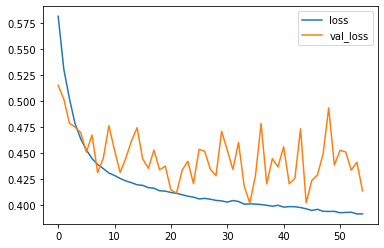

In [100]:
model_loss[['loss','val_loss']].plot()

## Final model metrics

In [101]:
yhat = model.predict_classes(X_test)

In [102]:
nn_result_tuned = ml_error( 'Neural network tuned', y_test, yhat )
nn_result_tuned

,Model Name,Recall,Balanced accuracy,F1 score,Kappa Metrics
0,Neural network tuned,0.699746,0.776133,0.607735,0.495584


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

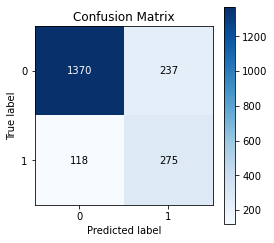

In [103]:
# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat, normalize=False, figsize=(4,4))

In [104]:
probs=model.predict_proba(X_test)
probs=np.concatenate((1-probs,probs),axis=1)
probs

array([[0.8735523 , 0.12644765],
       [0.9675553 , 0.03244472],
       [0.75444114, 0.24555883],
       ...,
       [0.06070924, 0.93929076],
       [0.71463215, 0.28536785],
       [0.45526117, 0.5447388 ]], dtype=float32)

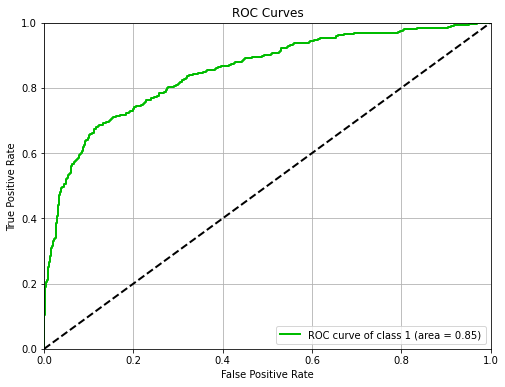

In [105]:
skplt.metrics.plot_roc(y_test.to_numpy(), probs, plot_micro=False, plot_macro=False, classes_to_plot=[1], figsize=(8,6))
# plt.legend(loc='center right', fontsize=12)
plt.ylim(0,1)
plt.grid(True)
plt.show()

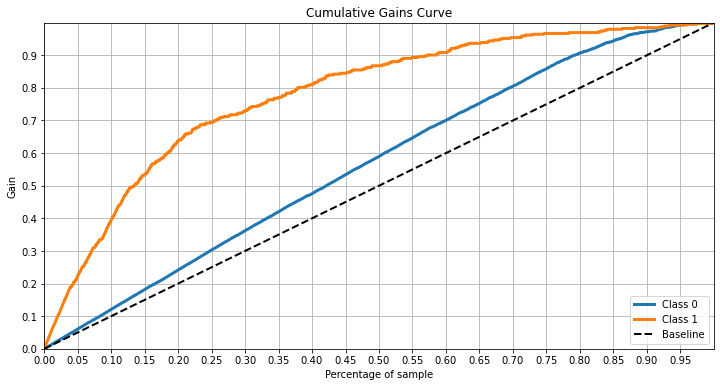

In [106]:
# plot cumulative gains curve
skplt.metrics.plot_cumulative_gain(y_test.to_numpy(), probs, figsize=(12,6))
plt.grid(True)
plt.xticks(np.arange(0, 1, step=0.05))
plt.yticks(np.arange(0, 1, step=0.1))
plt.show()

# Curve meaning example:
# using the model, if we contact only the 30% of clients with highest probability of churning,
# we will find 75% of the total numbers of churning clients in this sample

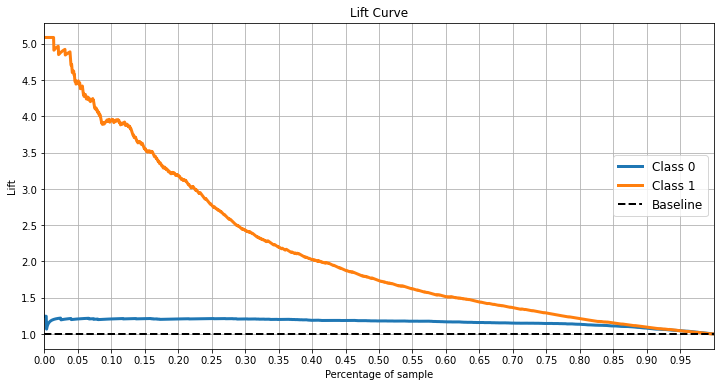

In [107]:
# plot Lift curve
skplt.metrics.plot_lift_curve(y_test.to_numpy(), probs, figsize=(12,6))
plt.legend(loc='center right', fontsize=12)
plt.xticks(np.arange(0, 1, step=0.05))
plt.xlim(0,1)
plt.show()

# Curve meaning example:
# using the model, if we contact 30% of clients with highest probability of churning,
# we will find 2.5 times more true positives than using no model.

In [108]:
 # calculate model predicted probabilities
probas=model.predict_proba(X_test)
# get positive class probabilities
y_scores = probas[:,0]
y_scores

array([0.12644765, 0.03244472, 0.24555883, ..., 0.93929076, 0.28536785,
       0.5447388 ], dtype=float32)

In [109]:
prob_group=pd.DataFrame({'true_value':y_test.to_numpy(),'y_scores':y_scores})
prob_group['y_scores']=pd.cut(prob_group['y_scores'],np.arange(0,1.1,0.1))
prob_group=prob_group.groupby('y_scores').sum()/prob_group.groupby('y_scores').count()
# prob_group=prob_group.groupby('y_scores').sum()/y_test.sum()
prob_group

,true_value
y_scores,
"(0.0, 0.1]",0.031546
"(0.1, 0.2]",0.084337
"(0.2, 0.3]",0.112903
"(0.3, 0.4]",0.160256
"(0.4, 0.5]",0.144068
"(0.5, 0.6]",0.216981
"(0.6, 0.7]",0.395833
"(0.7, 0.8]",0.438356
"(0.8, 0.9]",0.670213


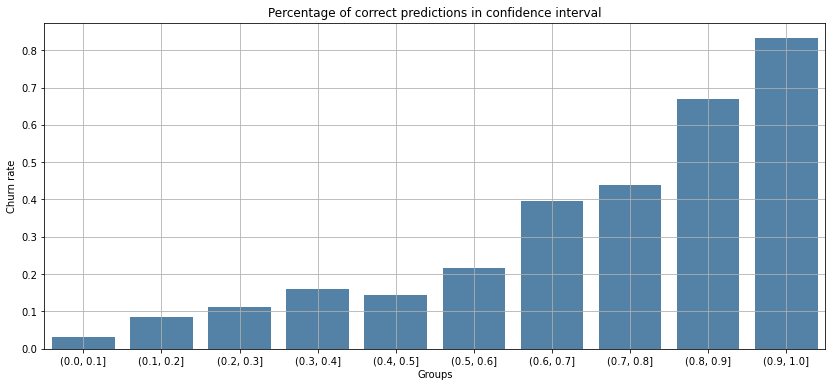

In [110]:
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(ax=ax,data=prob_group,x=prob_group.index,y='true_value',color='steelblue')
ax.set_title('Percentage of correct predictions in confidence interval')
ax.set_xlabel('Groups')
ax.set_ylabel('Churn rate')
ax.grid(True)

In [111]:
# skplt.metrics.plot_calibration_curve(y_test.to_numpy(), [probs[:,1].tolist()], figsize=(12,6),n_bins=10)
# # plt.legend(loc='center right', fontsize=12)
# plt.grid(True)
# plt.xticks(np.arange(0, 1, step=0.05))
# plt.xlim(0,1)
# plt.show()

In [112]:
# compute precision and recall for all possible thresholds
precisions, recalls, thresholds = m.precision_recall_curve(y_test.to_numpy(), y_scores)

note: increasing recall reduces FN and increases FP

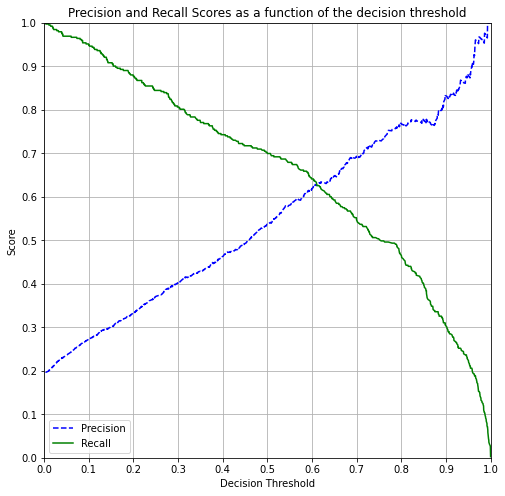

In [113]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
    
    plt.xticks(np.arange(0, 1.01, step=0.1))
    plt.yticks(np.arange(0, 1.01, step=0.1))
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.grid(True)
    
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [114]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# BUSINESS ANALYSIS

Bank account return per client:
* 15% for clients with estimated income lower than the average;
* 20% for clients with estimated income greater than the average.

**Deliverables**
* Answer the following business questions (8.1 section):
 * What is TopBank's current Churn rate? 
 * How does it vary monthly?
 * What is the model's performance in classifying customers as churns?
 * What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?
* Maximize ROI (8.2 section);
* Deployed model that receives a customers database through API and returns the probability if client churning;

In [115]:
# import data and divide in train and test again to get non scaled data
data = pd.read_csv('churn.csv')
x=data.drop(['Exited'],axis=1)
y=data['Exited']
xtrain, xtest, ytrain, ytest = ms.train_test_split(x,y,test_size=0.20,random_state=SEED)
train_set=pd.concat([xtrain,ytrain],axis=1)
test_set=pd.concat([xtest,ytest],axis=1)

In [116]:
df8=data.copy()

## Answers to business questions

### What is TopBank's current Churn rate?

A: current churn rate is 20%

In [117]:
df8[target].value_counts(normalize=True)

Exited
0         0.7963
1         0.2037
dtype: float64

### How does it vary monthly?

A: 4% of clients exit the bank per month on average

In [118]:
x=df8['IsActiveMember'].value_counts().loc[0]/len(df8) #proportion of clients that are not active in 12 months
x=(x/12)*100 #divide by 12 to get average per month
print('The monthly churn rate is {:.2f}%.'.format(x)) 

The monthly churn rate is 4.04%.


### What is the model's performance to classify clients as churns

A: Recall of 70%, i.e. 70% of clients that really churned are correctly classified as churning clients

In [119]:
m.recall_score(y_test, yhat)

0.6997455470737913

### What is the expected return, in terms of revenue, if the company uses the model to avoid churn from customers?

A: The return would increase in 17% if after applying the model we could reverse the decision of every predicted churning client (without accounting for costs of investments)

In [120]:
df8.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [121]:
avg_sal = df8['EstimatedSalary'].mean()
print('average salary: ',avg_sal)

average salary:  100090.239881


In [122]:
# Churn rate without any prediction
test_set[target].sum()/len(test_set)

Exited    0.1965
dtype: float64

In [123]:
test_set_pred=test_set.copy()

In [124]:
# Create column of predicted Churns
test_set_pred['prediction']=yhat

In [125]:
test_set_pred.sample(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,prediction
9414,9415,15632280,Toth,544,Spain,Female,53,9,0.00,1,1,0,125692.07,1,1
934,935,15790299,Williamson,592,Spain,Male,37,9,0.00,3,1,1,10656.89,0,0
3100,3101,15735549,Lori,810,Germany,Male,35,3,96814.46,2,1,1,120511.03,0,0


In [136]:
# Create column of churns if model can change decision of all predicted churn clients, i.e, if client was going to
# churn (exited=1), and the model predicts that he is going to churn (prediction=1), he is not going to churn anymore (exited_model=0)
test_set_pred['Exited_model']=test_set_pred.apply(lambda x: 0 if x['Exited']+x['prediction']==2 else x['Exited'],axis=1)

In [127]:
# #alternatively
# test_set_pred['Exited_model'] = test_set_pred['Exited_model'].apply(bool) & ~test_set_pred['prediction'].apply(bool)

In [128]:
test_set_pred.tail(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,prediction,Exited_model
132,133,15677871,Cocci,687,France,Male,38,9,122570.87,1,1,1,35608.88,0,0,0
7722,7723,15570086,Lynch,684,Germany,Male,18,9,90544.00,1,0,1,4777.23,0,0,0
8458,8459,15728542,Vorobyova,850,France,Female,71,4,0.00,2,1,1,107236.87,0,0,0
964,965,15580956,McNess,683,Germany,Female,43,4,115888.04,1,1,1,117349.19,1,1,0
8719,8720,15811415,Jenks,691,France,Female,44,6,134066.10,2,1,1,197572.41,0,0,0
6412,6413,15598982,Klein,602,Germany,Female,53,5,98268.84,1,0,1,45038.29,1,1,0
8285,8286,15572631,Ndubuisi,609,France,Male,25,10,0.00,1,0,1,109895.16,0,0,0
7853,7854,15746674,Miller,730,France,Female,47,7,0.00,1,1,0,33373.26,1,1,0
1095,1096,15689081,Wu,692,France,Male,29,4,0.00,1,1,0,76755.99,1,0,1
6929,6930,15651627,White,628,Germany,Male,39,1,115341.19,1,1,1,107674.30,1,1,0


In [129]:
# return before model (for each client)
not_exited=test_set_pred['Exited'].replace({0:1, 1:0}) #swap 0 for 1 to get not exited series
return_before_model=sum(test_set_pred['EstimatedSalary'].apply(lambda x: x*0.20 if x>avg_sal else x*0.15)*not_exited)
print('The total return before applying the model is: ',return_before_model)

The total return before applying the model is:  29514860.305499975


In [130]:
# return after model (for each client)
not_exited=test_set_pred['Exited_model'].replace({0:1, 1:0}) #swap 0 for 1 to get not exited series
return_after_model=sum(test_set_pred['EstimatedSalary'].apply(lambda x: x*0.20 if x>avg_sal else x*0.15)*not_exited)
print('The total return after applying the model is: ',return_after_model)

The total return after applying the model is:  34631163.94950001


In [131]:
inc=return_after_model/return_before_model
print('Increase of ',inc,'in return after applying model.')

Increase of  1.1733467003076627 in return after applying model.


## Maximize ROI to avoid churning

**Analysis**

Results from knapsack algorithm:
* Investment: 10,000.00
* Number of clients selected:  184
* Profit: 3,881,663.21
* Optimum revenue from recovered clients: 3,891,576.00
* Optimum ROI: 38,816.63%

Context: The company provided a budget of 10,000mu to invest in clients and avoid churning.

Goal: Optimize ROI (Return of Investment).

To optimize ROI without exceeding the budget of 10,000mu we must invest in clients with high probability of churning. The following strategy is considered to distribute the incentives among clients:

* For clients with extreme probability of churning, p(churn) > 0.99, invest nothing, these clients are too difficult to maintain and it's better letting go.
* If 0.95 < p(churn) < 0.99 invest 200mu
* If 0.90 < p(churn) < 0.95 invest 100mu
* If p(churn) < 0.90 invest 50mu

The above strategy, altought arbitrary, is realistic in a real business scenario.

Note: according to the cumulative curve, using the model, if we contact only the 10% of clients with highest probability of churning, we will find 40% of the total numbers of churning clients in this sample

In the above strategy we must select an optimal combination of clients that maximize the total returned value , without exceeding the total weight constraint.
So we summarize this problem in the following manner:
* Each client has a "weight": the financial incentive that will be given in order to avoid the churn.
* There is a total weight constraint, i.e., the available budget for investments: $ 10,000.00.
* The incentive can either be offered or not: 0-1 

The problem of selecting an optimal combination of weights and values with a total weight constraint can be solved using a **0-1 Knapsack algorithm**.

Knapsack Problem Reference:
* https://en.wikipedia.org/wiki/Knapsack_problem
* https://www.geeksforgeeks.org/python-program-for-dynamic-programming-set-10-0-1-knapsack-problem/

In [153]:
# Bank account return per client:
# * 15% for clients with estimated income lower than the average;
# * 20% for clients with estimated income greater than the average.
not_exited=test_set_pred['Exited'].replace({0:1, 1:0}) #swap 0 for 1 to get not exited series
test_set_pred['Return']=test_set_pred['EstimatedSalary'].apply(lambda x: x*0.20 if x>avg_sal else x*0.15)*not_exited

In [155]:
# Get probability of churning from model
probs=model.predict_proba(X_test)
test_set_pred['Probs']=probs.reshape((-1))

In [160]:
# list of available incentives as stated above
# the incentive of 20000 is for clients with p(churn) > 0.99, it will be discarded in the knapsack function
incentives_list = [20000, 200, 100, 50]
incentives = []
n = len(test_set_pred)

# set incentive value according churn predicted probability
for i in range(n):
    entry = test_set_pred.iloc[i]
    if entry['Probs'] >= 0.99:
        incentives.append(incentives_list[0])
    elif entry['Probs'] >= 0.95 and entry['Probs'] < 0.99:
        incentives.append(incentives_list[1])
    elif entry['Probs'] >= 0.90 and entry['Probs'] < 0.95:
        incentives.append(incentives_list[2])
    else:
        incentives.append(incentives_list[3])
        
test_set_pred['Incentives']=incentives

In [162]:
# filter clients in churn according model
aux = test_set_pred[test_set_pred['prediction']==1]

In [165]:
# set parameters for the knapsack function
val = aux['Return'].astype(int).values # return per client
wt = aux['Incentives'].values # incentive value per client
investment = 10000 # total amount of incentive according the problem

In [166]:
# calculate revenue with knapsack function
max_val, keep = knapsack(investment, wt, val)

In [178]:
aux.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'prediction',
       'Exited_model', 'Return', 'Probs', 'Incentives'],
      dtype='object')

In [190]:
# calculate profit per client
profit = (aux['Return'] - aux['Incentives']).sum()
# calculate ROI
roi = (profit / investment)*100

In [193]:
print('Results from knapsack algorithm:')

print('Investment: {:,.2f}'.format(investment))
print('Number of clients selected: ',len(aux))
print('Profit: {:,.2f}'.format(profit))
print('Optimum revenue from recovered clients: {:,.2f}'.format(max_val))
print('Optimum ROI: {:,.2f}%'.format(roi))

Results from knapsack algorithm:
Investment: 10,000.00
Number of clients selected:  184
Profit: 3,881,663.21
Optimum revenue from recovered clients: 3,891,576.00
Optimum ROI: 38,816.63%


# FINAL PIPELINE AND TRAINING FOR PRODUCTION

In [278]:
data_set=data.copy()

## Final pipeline

In [279]:
# DATA PREPARATION
# use one hot-encoding for gender
dic={'Male':0,'Female':1}
data_set['Gender']=data_set['Gender'].map(dic)
# use ordered target encoding for geography
dic={'Germany':0,'Spain':1,'France':2}
data_set['Geography']=data_set['Geography'].map(dic)

In [280]:
scaler = RobustScaler()
cols=continuous+discrete
data_set[cols]=scaler.fit_transform(data_set[cols].values)

In [281]:
data_set=data_set[cols_selected+target]

## Training model for production

In [282]:
X_train=data_set.drop(['Exited'],axis=1)
y_train=data_set['Exited']

In [283]:
model = ml.Sequential()
model.add( l.Dense( units=32, input_dim=X_train.shape[1], activation='relu') )
model.add( l.Dense( units=4, activation='relu') )
model.add( l.Dense( units=1, activation='sigmoid') )

# Compile model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [284]:
model.fit(x=X_train,y=y_train,epochs=50,verbose=1, batch_size=16)

Epoch 1/50
10000/10000 [==============================] - 1s 86us/sample - loss: 0.4407 - acc: 0.8078
Epoch 2/50
10000/10000 [==============================] - 1s 79us/sample - loss: 0.4078 - acc: 0.8313
Epoch 3/50
10000/10000 [==============================] - 1s 76us/sample - loss: 0.3890 - acc: 0.8382
Epoch 4/50
10000/10000 [==============================] - 1s 70us/sample - loss: 0.3734 - acc: 0.8447
Epoch 5/50
10000/10000 [==============================] - 1s 62us/sample - loss: 0.3606 - acc: 0.85240s - loss: 0.3435 - a
Epoch 6/50
10000/10000 [==============================] - 1s 61us/sample - loss: 0.3507 - acc: 0.8553
Epoch 7/50
10000/10000 [==============================] - 1s 63us/sample - loss: 0.3451 - acc: 0.8591
Epoch 8/50
10000/10000 [==============================] - 1s 65us/sample - loss: 0.3410 - acc: 0.8579
Epoch 9/50
10000/10000 [==============================] - 1s 65us/sample - loss: 0.3380 - acc: 0.8613
Epoch 10/50
10000/10000 [==============================] - 1s

In [285]:
model.save("model.h5")

In [286]:
joblib.dump(scaler,'robust_scaler.pkl')

['robust_scaler.pkl']